<a href="https://colab.research.google.com/github/aekanun2020/AdvancedStat/blob/main/2025_ih_EGAT_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00
# LAB 3: Exponential Smoothing และโมเดล ARIMA/SARIMA สำหรับการวิเคราะห์ข้อมูลอนุกรมเวลาในระบบไฟฟ้า

## ส่วนที่ 1: สร้างข้อมูลจำลองการผลิตไฟฟ้า
--------------------------------------------------
สร้างข้อมูลจำลองการผลิตไฟฟ้ารายชั่วโมง...

ตัวอย่างข้อมูล:
                     power_output  hour  day  dayofweek  month  year
2020-01-01 00:00:00   1009.934283     0    1          2      1  2020
2020-01-01 01:00:00   1023.271181     1    1          2      1  2020
2020-01-01 02:00:00   1063.265071     2    1          2      1  2020
2020-01-01 03:00:00   1101.641355     3    1          2      1  2020
2020-01-01 04:00:00   1050.656156     4    1          2      1  2020

สถิติพื้นฐานของข้อมูล:
count    26305.000000
mean      1478.602711
std        282.083079
min        780.879629
25%       1251.327148
50%       1424.011936
75%       1677.884459
max       2564.263511
Name: power_output, dtype: float64


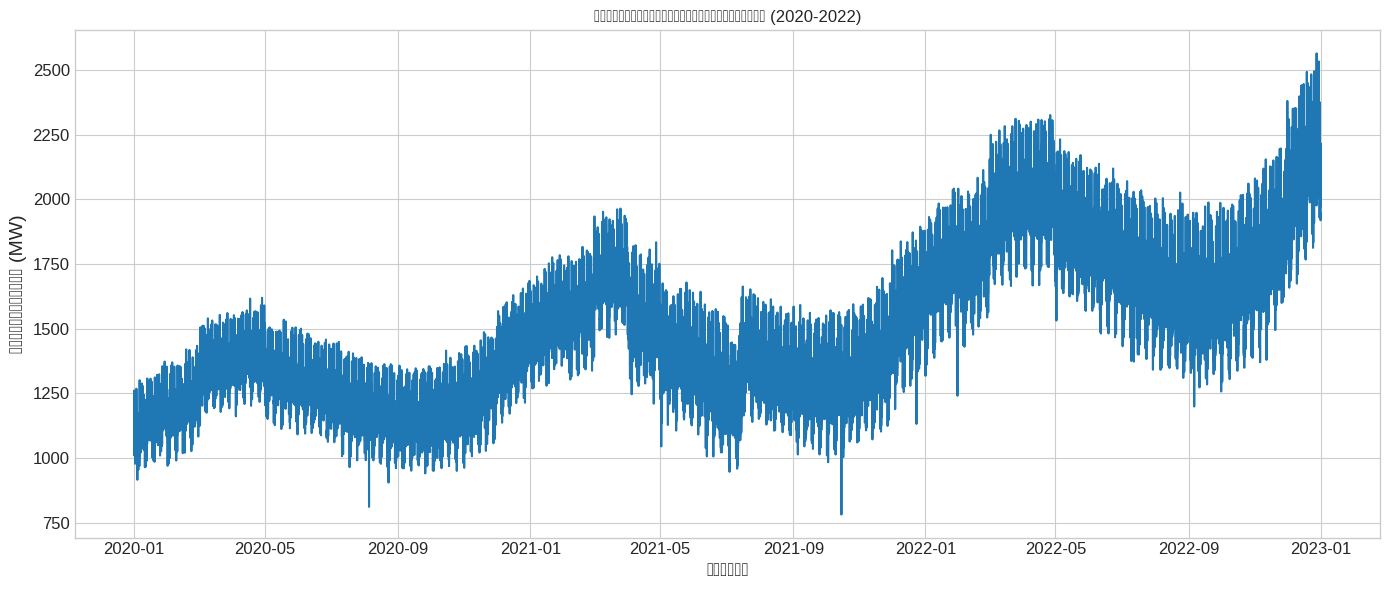

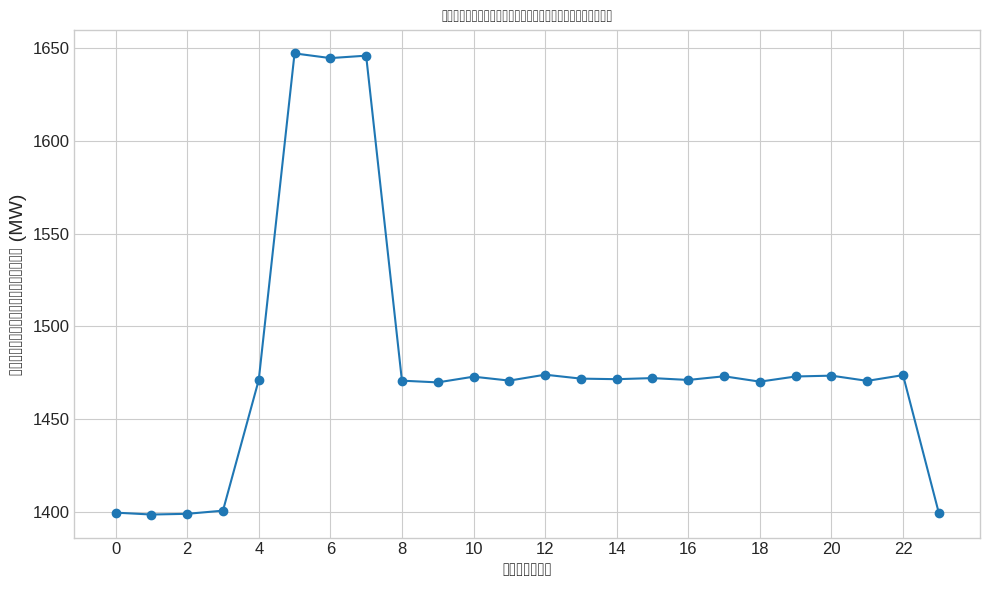

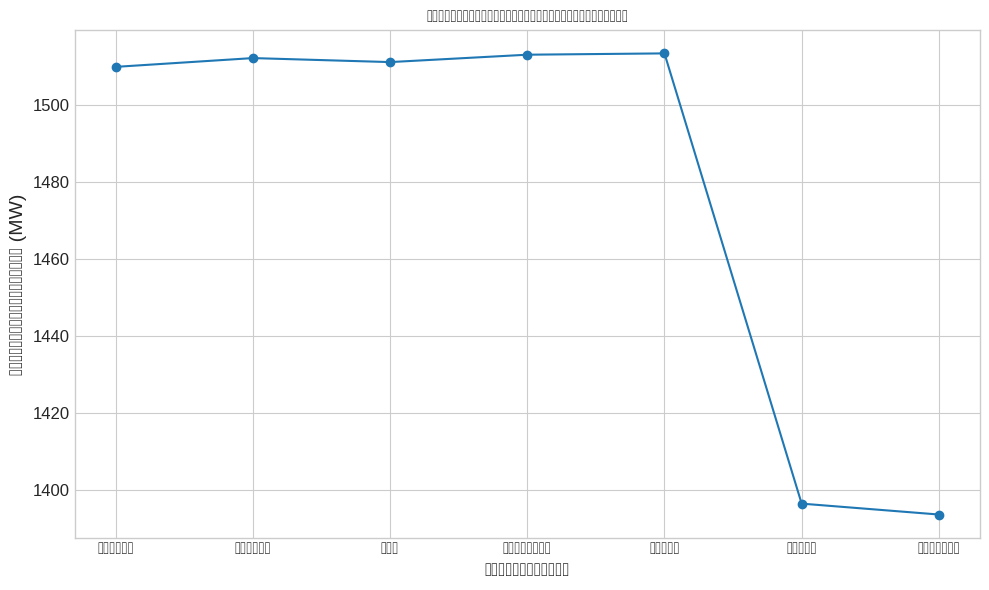

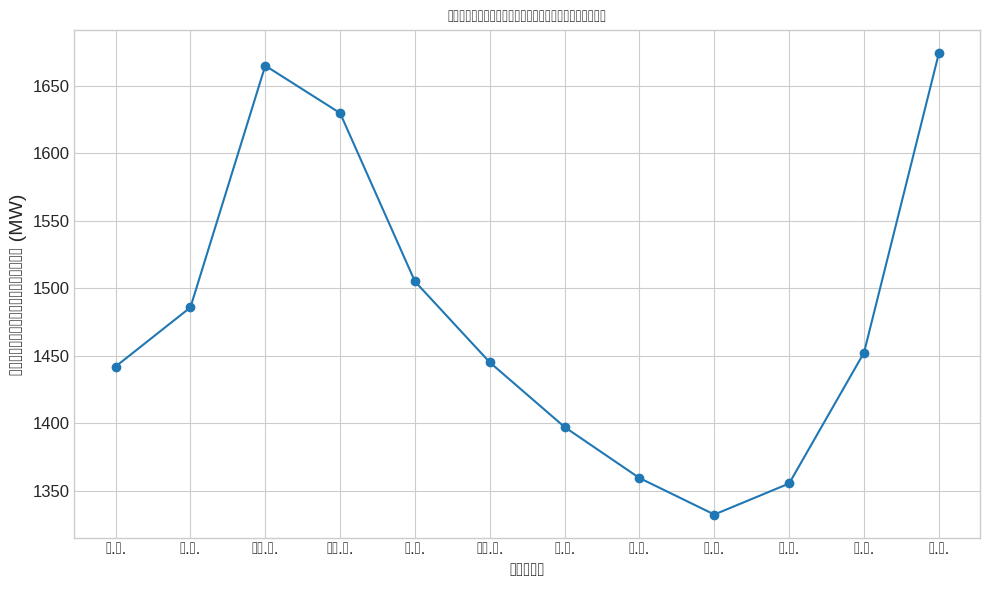


สร้างข้อมูลรายวันโดยการ resample จากข้อมูลรายชั่วโมง: 1097 วัน


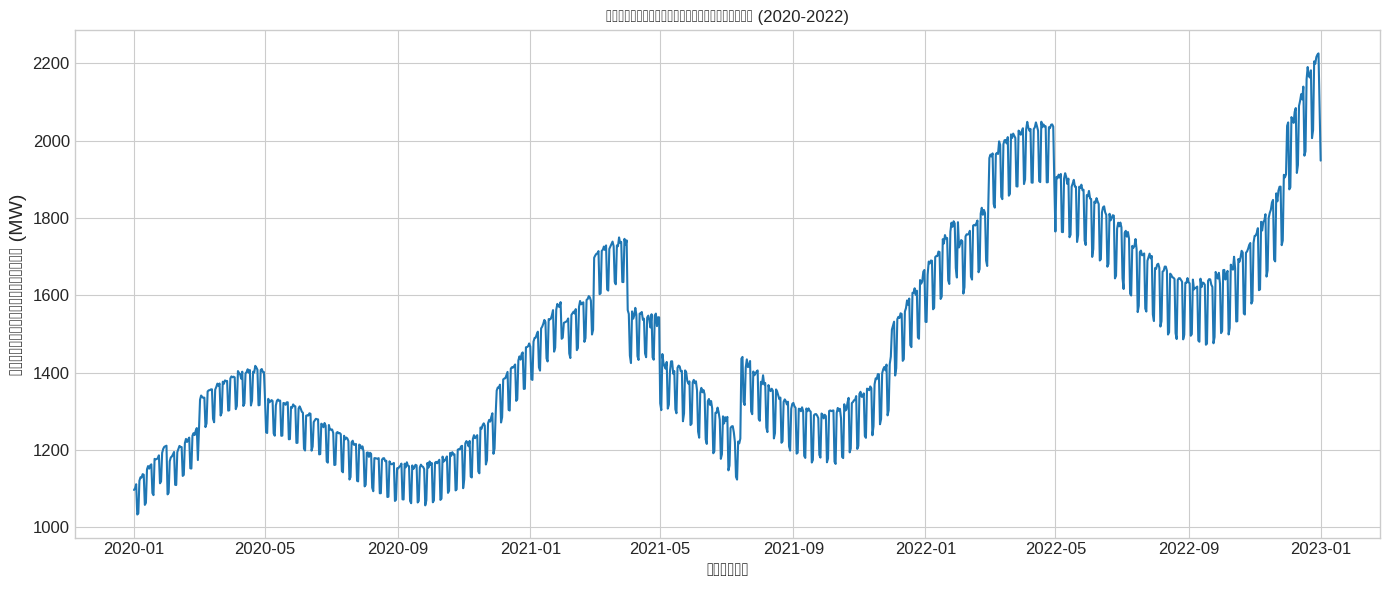

In [1]:
# Lab 3: Exponential Smoothing และโมเดล ARIMA/SARIMA
# สำหรับการวิเคราะห์ข้อมูลอนุกรมเวลาในระบบไฟฟ้า

# ติดตั้งแพ็คเกจที่จำเป็น
!pip install pandas numpy matplotlib seaborn statsmodels pmdarima scikit-learn

# นำเข้าไลบรารีที่จำเป็น
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# ปิดการแสดงคำเตือน
warnings.filterwarnings("ignore")

# กำหนดสไตล์กราฟ
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# กำหนด seed สำหรับ reproducibility
np.random.seed(42)

print("# LAB 3: Exponential Smoothing และโมเดล ARIMA/SARIMA สำหรับการวิเคราะห์ข้อมูลอนุกรมเวลาในระบบไฟฟ้า")
print("=" * 100)

# ---------------------------------------------------------------------------------
# ส่วนที่ 1: สร้างข้อมูลจำลองต่อเนื่องจาก Lab 1 และ Lab 2
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 1: สร้างข้อมูลจำลองการผลิตไฟฟ้า")
print("-" * 50)

def generate_simulated_power_data(start_date='2020-01-01', end_date='2023-01-01', hourly=True):
    """
    สร้างข้อมูลจำลองการผลิตไฟฟ้าที่ประกอบด้วยองค์ประกอบหลัก 4 อย่าง:
    1. แนวโน้ม (Trend): การเติบโต 3% ต่อปี พร้อมการปรับลดในช่วงกลาง
    2. ฤดูกาล (Seasonality): รายปี รายวัน รายสัปดาห์
    3. วัฏจักร (Cyclical): รูปแบบระยะยาวประมาณ 3 ปี
    4. ความไม่สม่ำเสมอ (Irregular): ความผันผวนแบบสุ่มและเหตุการณ์พิเศษ
    """

    # กำหนดช่วงเวลา
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    if hourly:
        # ข้อมูลรายชั่วโมง
        date_range = pd.date_range(start=start, end=end, freq='H')
    else:
        # ข้อมูลรายวัน
        date_range = pd.date_range(start=start, end=end, freq='D')

    df = pd.DataFrame(index=date_range)
    n_periods = len(df)

    # 1. แนวโน้ม (Trend) - การเติบโต 3% ต่อปี พร้อมการปรับลดในช่วงกลาง
    base_power = 1000  # กำลังการผลิตพื้นฐาน (MW)

    # สร้างแนวโน้มแบบไม่เชิงเส้น
    trend = np.linspace(0, 1, n_periods)
    # เพิ่มการลดลงในช่วงกลาง
    midpoint = n_periods // 2
    adjustment = np.sin(np.linspace(0, np.pi, n_periods)) * 0.1
    trend = trend * (1 + 0.03) - adjustment  # การเติบโต 3% ต่อปี พร้อมการปรับลดในช่วงกลาง
    trend = base_power * (1 + trend)

    # 2. ฤดูกาล (Seasonality)
    # 2.1 ฤดูกาลรายปี
    if hourly:
        annual_cycle = 365 * 24  # จำนวนชั่วโมงในหนึ่งปี
    else:
        annual_cycle = 365  # จำนวนวันในหนึ่งปี

    annual_seasonality = np.sin(2 * np.pi * np.arange(n_periods) / annual_cycle) * 0.15
    # ปรับให้สูงในช่วงมีนาคม-เมษายน และธันวาคม
    month_index = pd.Series(df.index.month)
    spring_mask = month_index.isin([3, 4])
    winter_mask = month_index.isin([12, 1])
    annual_seasonality += spring_mask.values * 0.07 + winter_mask.values * 0.05

    # 2.2 ฤดูกาลรายวัน (สำหรับข้อมูลรายชั่วโมง)
    if hourly:
        daily_seasonality = np.sin(2 * np.pi * np.arange(n_periods) % 24 / 24) * 0.1
        # ปรับให้สูงในช่วง 5-7 นาฬิกา และต่ำในช่วงกลางคืน
        hour_index = pd.Series(df.index.hour)
        peak_hours_mask = hour_index.isin([5, 6, 7])
        night_hours_mask = hour_index.isin([23, 0, 1, 2, 3])
        daily_seasonality += peak_hours_mask.values * 0.12 - night_hours_mask.values * 0.05
    else:
        daily_seasonality = 0

    # 2.3 ฤดูกาลรายสัปดาห์
    weekday = df.index.dayofweek
    weekend_mask = (weekday >= 5)  # 5 = เสาร์, 6 = อาทิตย์
    weekly_seasonality = np.where(weekend_mask, -0.08, 0)  # ลดลง 8% ในวันหยุดสุดสัปดาห์

    # 3. วัฏจักร (Cyclical) - รูปแบบทุก 3 ปี
    if hourly:
        cycle_length = 3 * 365 * 24  # 3 ปีในชั่วโมง
    else:
        cycle_length = 3 * 365  # 3 ปีในวัน

    cyclical = np.sin(2 * np.pi * np.arange(n_periods) / cycle_length) * 0.08

    # 4. ความไม่สม่ำเสมอ (Irregular)
    # 4.1 ความผันผวนทั่วไป
    noise = np.random.normal(0, 0.02, n_periods)

    # 4.2 เหตุการณ์พิเศษ (เช่น การซ่อมบำรุง, เหตุการณ์ฉุกเฉิน)
    special_events = np.zeros(n_periods)

    # สร้างช่วงการซ่อมบำรุงที่ทำให้การผลิตลดลง (เมษายน-กรกฎาคม 2021)
    if hourly:
        maintenance_start = pd.to_datetime('2021-04-01')
        maintenance_end = pd.to_datetime('2021-07-15')
        for i, dt in enumerate(df.index):
            if maintenance_start <= dt <= maintenance_end:
                # ลดการผลิตลงในช่วงซ่อมบำรุง
                special_events[i] = -0.15 + np.random.normal(0, 0.03)
    else:
        maintenance_dates = pd.date_range(start='2021-04-01', end='2021-07-15')
        maintenance_mask = df.index.isin(maintenance_dates)
        special_events[maintenance_mask] = -0.15 + np.random.normal(0, 0.03, sum(maintenance_mask))

    # สร้างเหตุการณ์ฉุกเฉินที่ทำให้การผลิตลดลงอย่างมากในบางวัน
    n_events = 10
    event_indices = np.random.choice(range(n_periods), n_events, replace=False)
    special_events[event_indices] = -0.3 + np.random.normal(0, 0.05, n_events)

    # รวมทุกองค์ประกอบ
    power_output = trend * (1 + annual_seasonality + daily_seasonality + weekly_seasonality + cyclical + noise + special_events)

    # สร้าง DataFrame
    df['power_output'] = power_output

    # เพิ่มคอลัมน์จำแนกข้อมูล
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek  # 0=จันทร์, 6=อาทิตย์
    df['month'] = df.index.month
    df['year'] = df.index.year

    return df

# สร้างข้อมูลจำลอง
print("สร้างข้อมูลจำลองการผลิตไฟฟ้ารายชั่วโมง...")
data = generate_simulated_power_data(start_date='2020-01-01', end_date='2023-01-01', hourly=True)

# แสดงข้อมูล 5 แถวแรก
print("\nตัวอย่างข้อมูล:")
print(data.head())

# แสดงข้อมูลทางสถิติพื้นฐาน
print("\nสถิติพื้นฐานของข้อมูล:")
print(data['power_output'].describe())

# แสดงกราฟข้อมูล
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['power_output'])
plt.title('ข้อมูลการผลิตไฟฟ้ารายชั่วโมง (2020-2022)')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิต (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# แสดงผลเชิงฤดูกาล
# แสดงข้อมูลตามชั่วโมง
hourly_avg = data.groupby('hour')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('การผลิตไฟฟ้าเฉลี่ยตามชั่วโมง')
plt.xlabel('ชั่วโมง')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.tight_layout()
plt.show()

# แสดงข้อมูลตามวันในสัปดาห์
daily_avg = data.groupby('dayofweek')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o')
plt.title('การผลิตไฟฟ้าเฉลี่ยตามวันในสัปดาห์')
plt.xlabel('วันในสัปดาห์')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.xticks(range(0, 7), ['จันทร์', 'อังคาร', 'พุธ', 'พฤหัสบดี', 'ศุกร์', 'เสาร์', 'อาทิตย์'])
plt.grid(True)
plt.tight_layout()
plt.show()

# แสดงข้อมูลตามเดือน
monthly_avg = data.groupby('month')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('การผลิตไฟฟ้าเฉลี่ยตามเดือน')
plt.xlabel('เดือน')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.xticks(range(1, 13), ['ม.ค.', 'ก.พ.', 'มี.ค.', 'เม.ย.', 'พ.ค.', 'มิ.ย.', 'ก.ค.', 'ส.ค.', 'ก.ย.', 'ต.ค.', 'พ.ย.', 'ธ.ค.'])
plt.grid(True)
plt.tight_layout()
plt.show()

# สมมติว่าเราทำงานกับข้อมูลรายวัน
daily_data = data.resample('D').mean()
print(f"\nสร้างข้อมูลรายวันโดยการ resample จากข้อมูลรายชั่วโมง: {daily_data.shape[0]} วัน")

# แสดงข้อมูลรายวัน
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['power_output'])
plt.title('ข้อมูลการผลิตไฟฟ้ารายวัน (2020-2022)')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


## ส่วนที่ 2: การเตรียมข้อมูลและการแบ่งชุดข้อมูล
--------------------------------------------------
ขนาดชุดข้อมูล:
ข้อมูลทั้งหมด: 1097 วัน
ชุดข้อมูลฝึกสอน: 1065 วัน (ม.ค. 2020 - พ.ย. 2022)
ชุดข้อมูลทดสอบ: 32 วัน (ธ.ค. 2022)


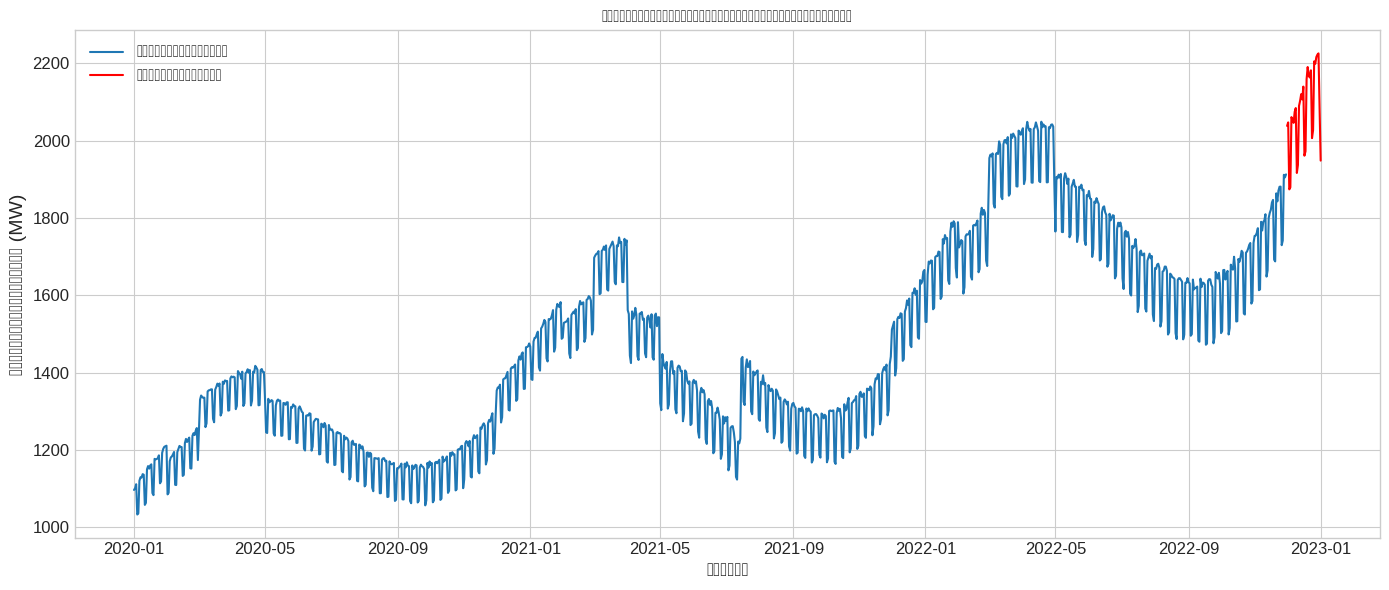

In [2]:
# ---------------------------------------------------------------------------------
# ส่วนที่ 2: แยกชุดข้อมูลสำหรับการฝึกและทดสอบโมเดล
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 2: การเตรียมข้อมูลและการแบ่งชุดข้อมูล")
print("-" * 50)

# เตรียมข้อมูลสำหรับการสร้างโมเดล
# แบ่งข้อมูลเป็นชุดฝึกสอน (training) และชุดทดสอบ (test)
# เลือกใช้ข้อมูลถึงสิ้นเดือนพฤศจิกายน 2022 เป็นชุดฝึกสอน และเดือนธันวาคม 2022 เป็นชุดทดสอบ
train_data = daily_data[:'2022-11-30']
test_data = daily_data['2022-12-01':]

print(f"ขนาดชุดข้อมูล:")
print(f"ข้อมูลทั้งหมด: {len(daily_data)} วัน")
print(f"ชุดข้อมูลฝึกสอน: {len(train_data)} วัน (ม.ค. 2020 - พ.ย. 2022)")
print(f"ชุดข้อมูลทดสอบ: {len(test_data)} วัน (ธ.ค. 2022)")

# แสดงกราฟชุดข้อมูลฝึกสอนและทดสอบ
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['power_output'], label='ชุดข้อมูลฝึกสอน')
plt.plot(test_data.index, test_data['power_output'], label='ชุดข้อมูลทดสอบ', color='red')
plt.title('การแบ่งข้อมูลสำหรับการฝึกสอนและทดสอบโมเดล')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ฟังก์ชันสำหรับคำนวณเมทริกซ์ประเมินผล
def calculate_metrics(actual, forecast):
    """คำนวณเมทริกซ์ต่างๆ สำหรับการประเมินผลโมเดล"""
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# ฟังก์ชันสำหรับแสดงผลการพยากรณ์
def plot_forecast_results(train_data, test_data, forecast, model_name):
    """แสดงผลการพยากรณ์เทียบกับข้อมูลจริง"""
    plt.figure(figsize=(14, 6))
    plt.plot(train_data.index, train_data['power_output'], label='ข้อมูลฝึกสอน')
    plt.plot(test_data.index, test_data['power_output'], label='ข้อมูลจริง', color='blue')
    plt.plot(test_data.index, forecast, label='ค่าพยากรณ์', color='red', linestyle='--')
    plt.title(f'ผลการพยากรณ์ด้วยโมเดล {model_name}')
    plt.xlabel('วันที่')
    plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # แสดงค่าเมทริกซ์
    metrics = calculate_metrics(test_data['power_output'], forecast)
    print(f"\nผลการประเมินโมเดล {model_name}:")
    print(f"MAE: {metrics['MAE']:.2f} MW")
    print(f"RMSE: {metrics['RMSE']:.2f} MW")
    print(f"MAPE: {metrics['MAPE']:.2f}%")

    return metrics


## ส่วนที่ 3: การสร้างโมเดล Exponential Smoothing
--------------------------------------------------

### 3.1 Simple Exponential Smoothing (SES)
เหมาะสำหรับข้อมูลที่ไม่มีแนวโน้มและฤดูกาล


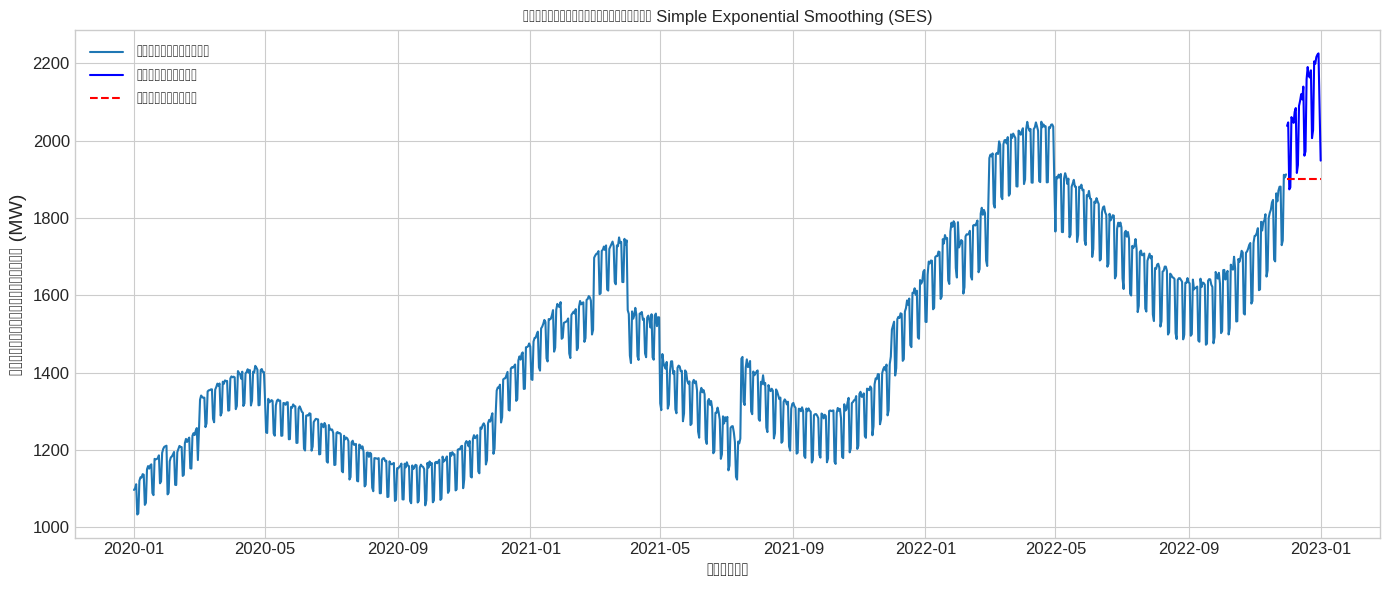


ผลการประเมินโมเดล Simple Exponential Smoothing (SES):
MAE: 180.19 MW
RMSE: 203.86 MW
MAPE: 8.47%

### 3.2 Holt's Exponential Smoothing
เหมาะสำหรับข้อมูลที่มีแนวโน้มแต่ไม่มีฤดูกาล


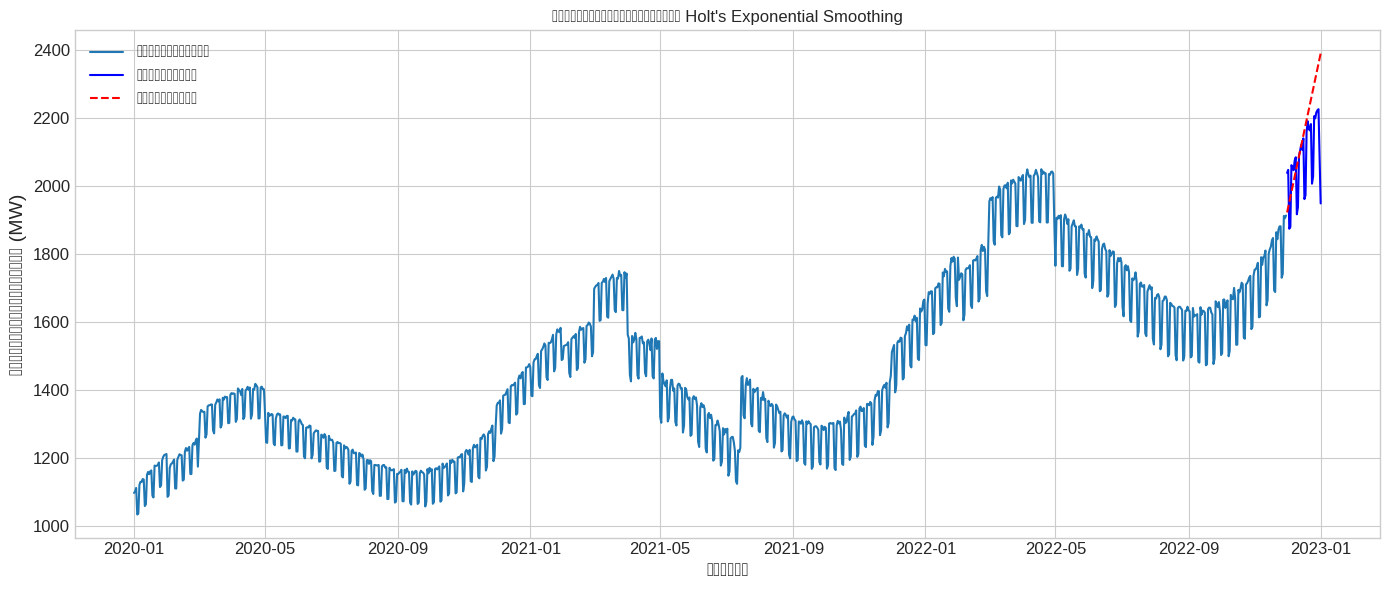


ผลการประเมินโมเดล Holt's Exponential Smoothing:
MAE: 108.19 MW
RMSE: 145.14 MW
MAPE: 5.30%

### 3.3 Holt-Winters' Exponential Smoothing
เหมาะสำหรับข้อมูลที่มีทั้งแนวโน้มและฤดูกาล


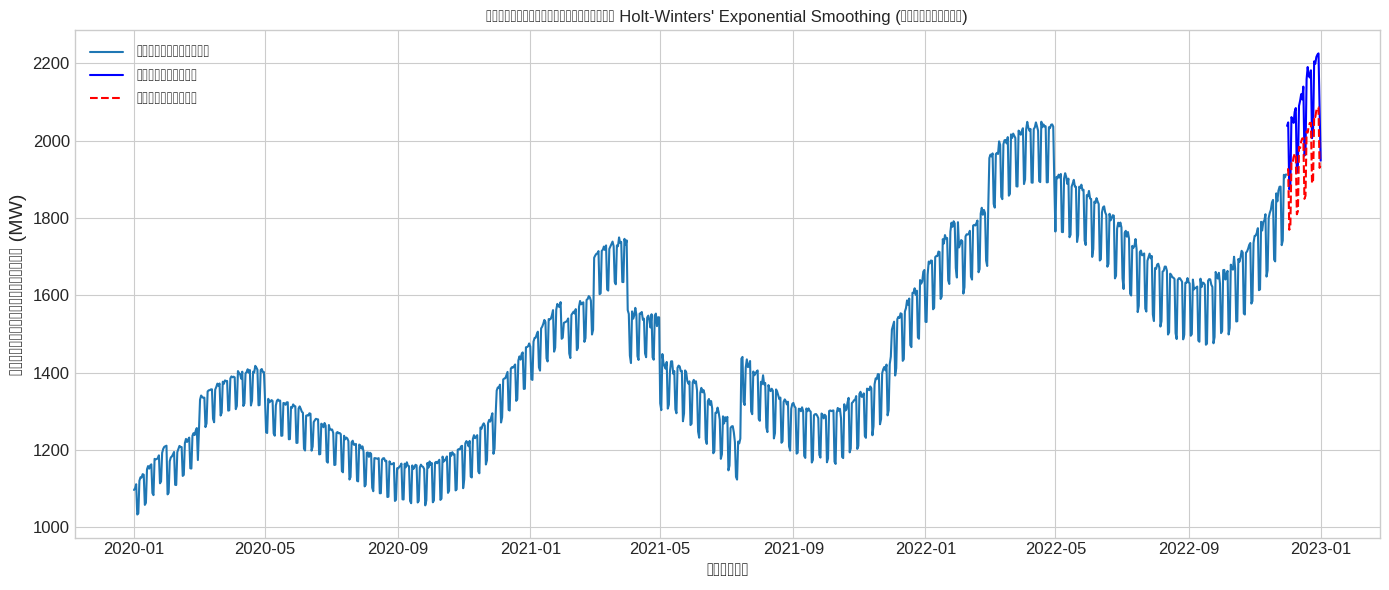


ผลการประเมินโมเดล Holt-Winters' Exponential Smoothing (รายสัปดาห์):
MAE: 119.38 MW
RMSE: 122.08 MW
MAPE: 5.72%

### 3.4 Holt-Winters' Exponential Smoothing (รายเดือน)


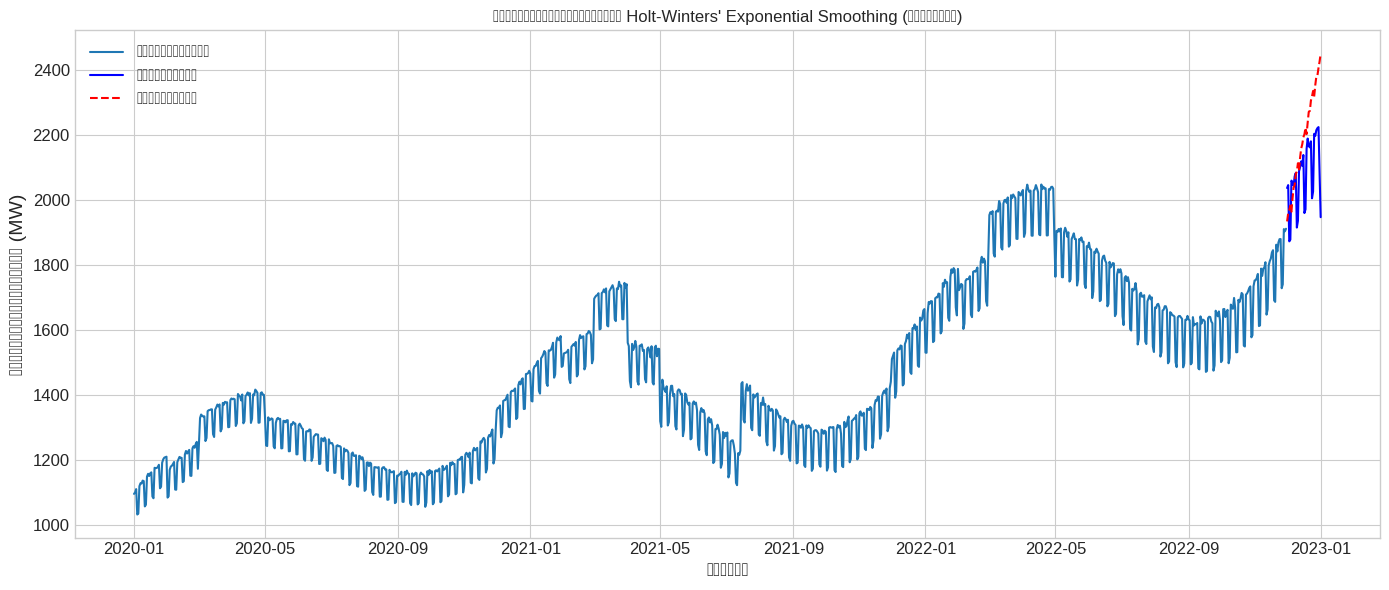


ผลการประเมินโมเดล Holt-Winters' Exponential Smoothing (รายเดือน):
MAE: 134.25 MW
RMSE: 174.78 MW
MAPE: 6.55%

### 3.5 เปรียบเทียบประสิทธิภาพของโมเดล Exponential Smoothing

ตารางเปรียบเทียบประสิทธิภาพของโมเดล Exponential Smoothing:
           Simple Exponential Smoothing  Holt Exponential Smoothing  \
MAE (MW)                     180.191149                  108.186324   
RMSE (MW)                    203.855670                  145.141527   
MAPE (%)                       8.465903                    5.304502   

           Holt-Winters (รายสัปดาห์)  Holt-Winters (รายเดือน)  
MAE (MW)                  119.378856               134.250383  
RMSE (MW)                 122.076245               174.776084  
MAPE (%)                    5.722895                 6.554507  


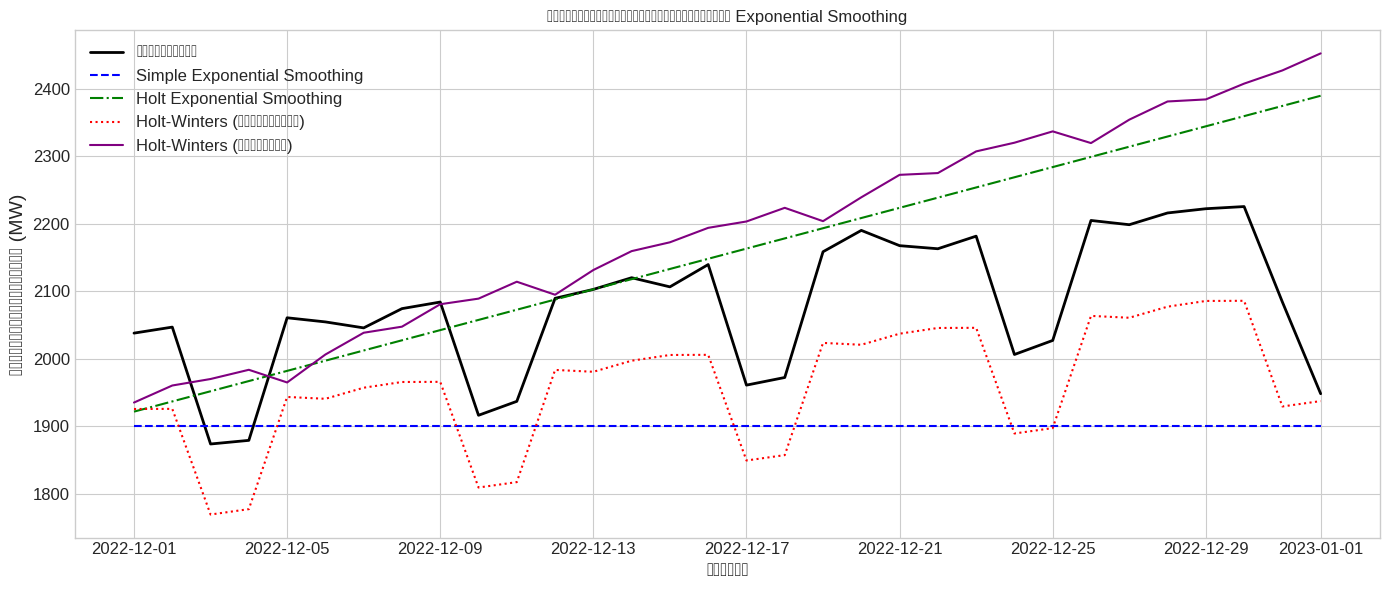

In [3]:
# ---------------------------------------------------------------------------------
# ส่วนที่ 3: การสร้างโมเดล Exponential Smoothing
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 3: การสร้างโมเดล Exponential Smoothing")
print("-" * 50)

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 3.1 Simple Exponential Smoothing (SES)
print("\n### 3.1 Simple Exponential Smoothing (SES)")
print("เหมาะสำหรับข้อมูลที่ไม่มีแนวโน้มและฤดูกาล")

# สร้างโมเดล Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train_data['power_output'])
ses_fit = ses_model.fit(smoothing_level=0.6, optimized=False)

# พยากรณ์ล่วงหน้า
ses_forecast = ses_fit.forecast(len(test_data))

# แสดงผลการพยากรณ์
ses_metrics = plot_forecast_results(train_data, test_data, ses_forecast, 'Simple Exponential Smoothing (SES)')

# 3.2 Holt's Exponential Smoothing
print("\n### 3.2 Holt's Exponential Smoothing")
print("เหมาะสำหรับข้อมูลที่มีแนวโน้มแต่ไม่มีฤดูกาล")

# สร้างโมเดล Holt's Exponential Smoothing
holt_model = ExponentialSmoothing(train_data['power_output'], trend='add', seasonal=None)
holt_fit = holt_model.fit(smoothing_level=0.6, smoothing_trend=0.2)

# พยากรณ์ล่วงหน้า
holt_forecast = holt_fit.forecast(len(test_data))

# แสดงผลการพยากรณ์
holt_metrics = plot_forecast_results(train_data, test_data, holt_forecast, "Holt's Exponential Smoothing")

# 3.3 Holt-Winters' Exponential Smoothing
print("\n### 3.3 Holt-Winters' Exponential Smoothing")
print("เหมาะสำหรับข้อมูลที่มีทั้งแนวโน้มและฤดูกาล")

# สร้างโมเดล Holt-Winters' Exponential Smoothing
# กำหนด seasonal_periods=365 สำหรับฤดูกาลรายปี
hw_model = ExponentialSmoothing(
    train_data['power_output'],
    trend='add',
    seasonal='add',
    seasonal_periods=7  # เริ่มจากรูปแบบรายสัปดาห์ก่อน เนื่องจากมีข้อมูลไม่มากพอสำหรับรายปี (365)
)
hw_fit = hw_model.fit(smoothing_level=0.6, smoothing_trend=0.2, smoothing_seasonal=0.2)

# พยากรณ์ล่วงหน้า
hw_forecast = hw_fit.forecast(len(test_data))

# แสดงผลการพยากรณ์
hw_metrics = plot_forecast_results(train_data, test_data, hw_forecast, "Holt-Winters' Exponential Smoothing (รายสัปดาห์)")

# 3.4 ทดลองใช้ Holt-Winters' กับรูปแบบรายเดือน
print("\n### 3.4 Holt-Winters' Exponential Smoothing (รายเดือน)")

# สร้างโมเดล Holt-Winters' Exponential Smoothing
hw_monthly_model = ExponentialSmoothing(
    train_data['power_output'],
    trend='add',
    seasonal='add',
    seasonal_periods=30  # ประมาณ 1 เดือน
)
hw_monthly_fit = hw_monthly_model.fit(smoothing_level=0.6, smoothing_trend=0.2, smoothing_seasonal=0.2)

# พยากรณ์ล่วงหน้า
hw_monthly_forecast = hw_monthly_fit.forecast(len(test_data))

# แสดงผลการพยากรณ์
hw_monthly_metrics = plot_forecast_results(train_data, test_data, hw_monthly_forecast, "Holt-Winters' Exponential Smoothing (รายเดือน)")

# 3.5 เปรียบเทียบประสิทธิภาพของแต่ละโมเดล
print("\n### 3.5 เปรียบเทียบประสิทธิภาพของโมเดล Exponential Smoothing")

# สร้างตารางเปรียบเทียบ
comparison_df = pd.DataFrame({
    'Simple Exponential Smoothing': [ses_metrics['MAE'], ses_metrics['RMSE'], ses_metrics['MAPE']],
    'Holt Exponential Smoothing': [holt_metrics['MAE'], holt_metrics['RMSE'], holt_metrics['MAPE']],
    'Holt-Winters (รายสัปดาห์)': [hw_metrics['MAE'], hw_metrics['RMSE'], hw_metrics['MAPE']],
    'Holt-Winters (รายเดือน)': [hw_monthly_metrics['MAE'], hw_monthly_metrics['RMSE'], hw_monthly_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nตารางเปรียบเทียบประสิทธิภาพของโมเดล Exponential Smoothing:")
print(comparison_df)

# แสดงกราฟเปรียบเทียบการพยากรณ์
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='ข้อมูลจริง', color='black', linewidth=2)
plt.plot(test_data.index, ses_forecast, label='Simple Exponential Smoothing', color='blue', linestyle='--')
plt.plot(test_data.index, holt_forecast, label='Holt Exponential Smoothing', color='green', linestyle='-.')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters (รายสัปดาห์)', color='red', linestyle=':')
plt.plot(test_data.index, hw_monthly_forecast, label='Holt-Winters (รายเดือน)', color='purple', linestyle='-')
plt.title('เปรียบเทียบการพยากรณ์ด้วยโมเดล Exponential Smoothing')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# สรุปผลการวิเคราะห


## ส่วนที่ 4: การวิเคราะห์ ACF และ PACF และการเลือกพารามิเตอร์สำหรับโมเดล ARIMA
--------------------------------------------------

### 4.1 ตรวจสอบความคงที่ของข้อมูล (Stationarity Check)
ทดสอบความคงที่ของข้อมูลต้นฉบับ:
ADF Statistic: -1.3991
p-value: 0.5827
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682
ข้อมูลไม่มีความคงที่ (Non-stationary) อาจต้องทำการแปลงข้อมูลก่อนใช้โมเดล ARIMA

ทำ First-order differencing เพื่อให้ข้อมูลมีความคงที่มากขึ้น:
ADF Statistic: -4.5450
p-value: 0.0002
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682
ข้อมูลมีความคงที่ (Stationary) เพียงพอสำหรับการใช้โมเดล ARIMA


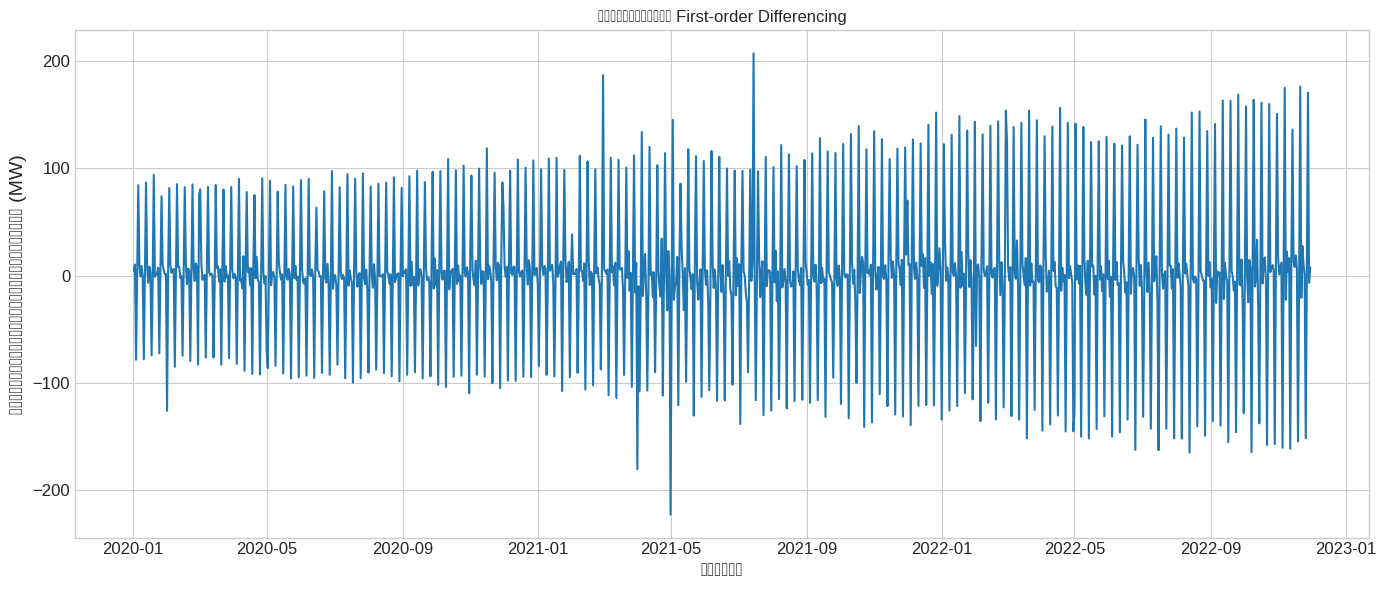


### 4.2 วิเคราะห์ ACF และ PACF

วิเคราะห์ ACF และ PACF ของข้อมูลต้นฉบับ:


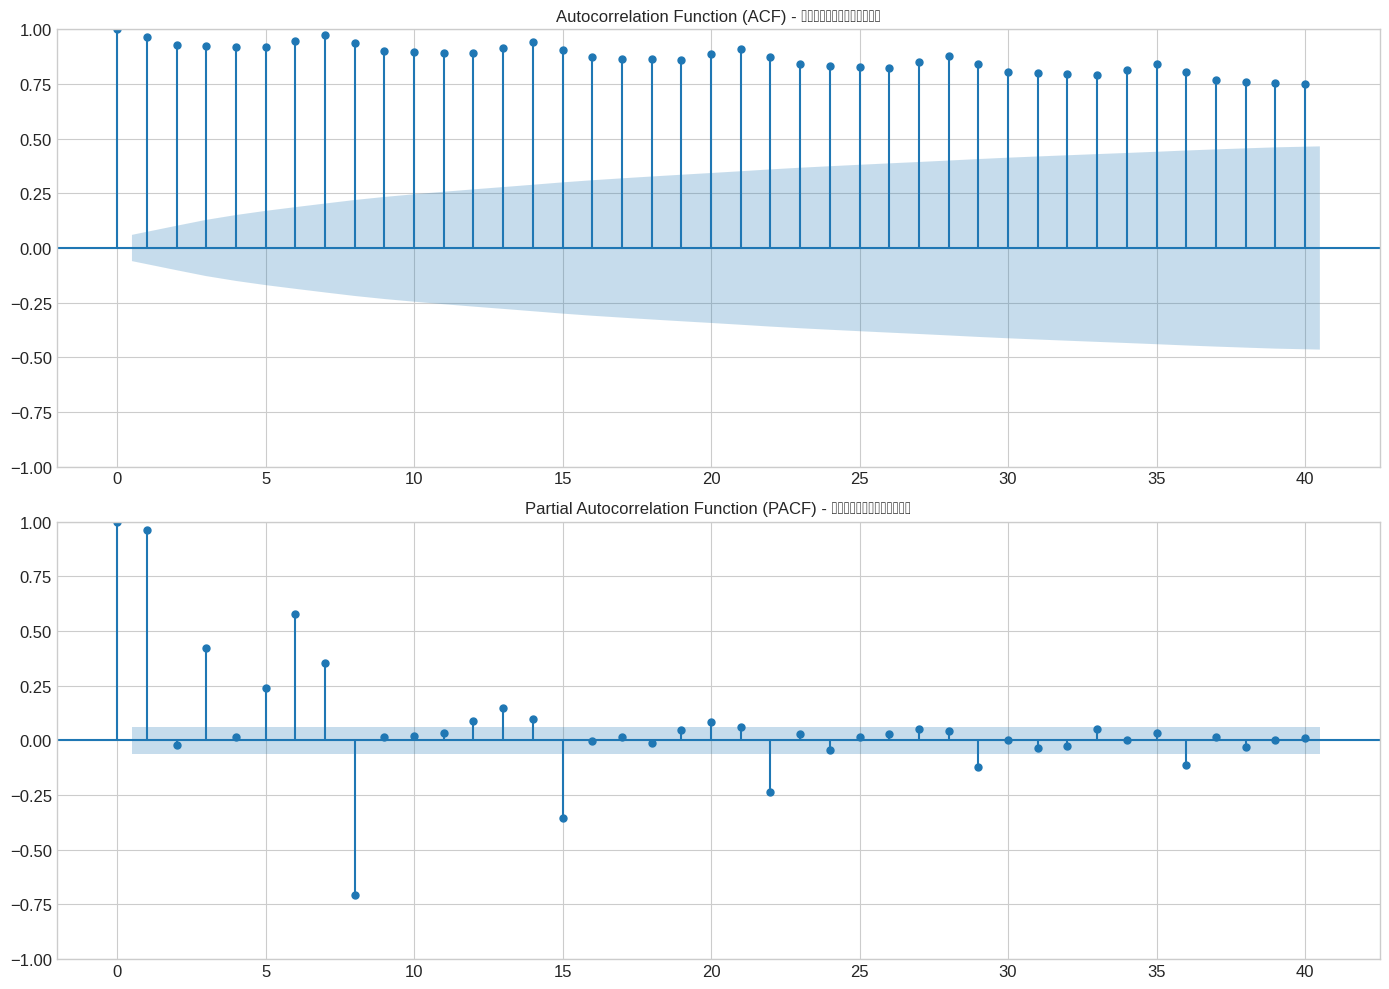


วิเคราะห์ ACF และ PACF ของข้อมูลหลังทำ First-order Differencing:


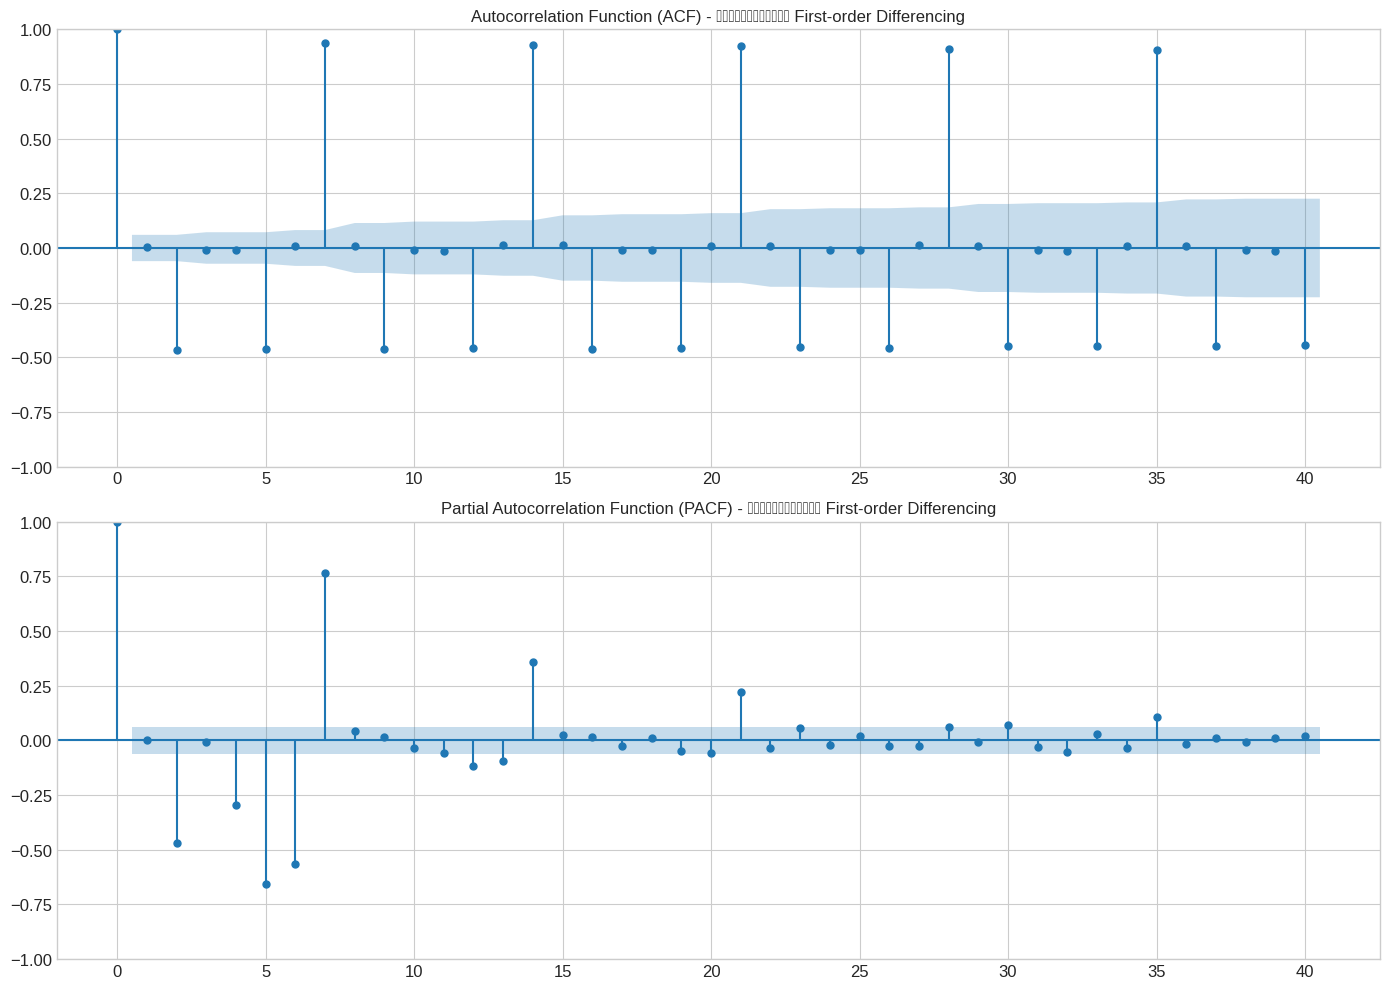


### 4.3 การเลือกพารามิเตอร์สำหรับโมเดล ARIMA

การเลือกพารามิเตอร์ p, d, q สำหรับโมเดล ARIMA(p,d,q):
- p: จำนวน lag ที่มีนัยสำคัญใน PACF (AR term)
- d: จำนวนครั้งที่ทำ differencing (0 ถ้าข้อมูลมีความคงที่, 1 ถ้าทำ first-order differencing)
- q: จำนวน lag ที่มีนัยสำคัญใน ACF หลังจากพิจารณา AR term (MA term)

จากการวิเคราะห์ ACF และ PACF:
ข้อมูลไม่มีความคงที่ ต้องทำ first-order differencing ดังนั้น d = 1
พิจารณา PACF ของข้อมูลหลัง differencing พบว่ามีนัยสำคัญที่ lag 1 ดังนั้นอาจเลือก p = 1
พิจารณา ACF ของข้อมูลหลัง differencing พบว่ามีนัยสำคัญที่ lag 1 ดังนั้นอาจเลือก q = 1
ดังนั้น อาจเลือกใช้โมเดล ARIMA(1,1,1)

### 4.4 การสร้างโมเดล ARIMA ด้วยพารามิเตอร์ที่เลือก
สร้างโมเดล ARIMA(1,1,1)

สรุปโมเดล ARIMA:
                               SARIMAX Results                                
Dep. Variable:           power_output   No. Observations:                 1065
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5840.048
Date:                Mon, 14 Apr 2025   AIC        

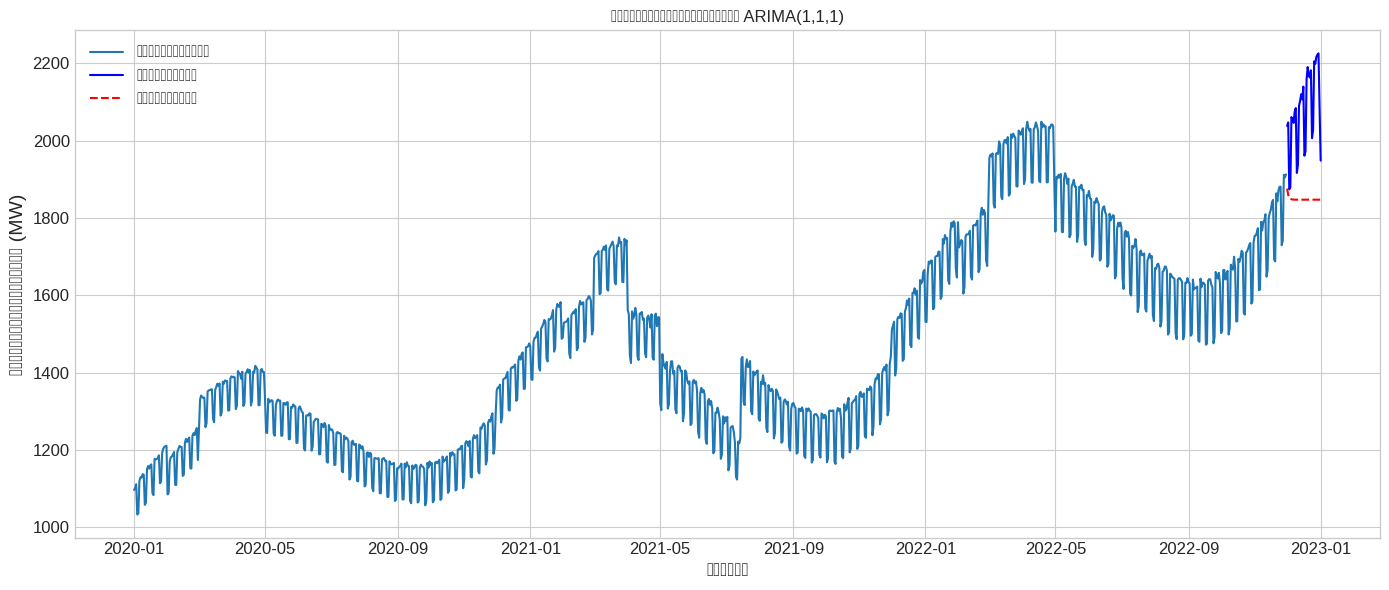


ผลการประเมินโมเดล ARIMA(1,1,1):
MAE: 229.29 MW
RMSE: 250.96 MW
MAPE: 10.82%

### 4.5 การใช้ Manual Auto-ARIMA เพื่อหาพารามิเตอร์ที่เหมาะสมที่สุด
Manual Auto-ARIMA จะทดลองพารามิเตอร์หลากหลายรูปแบบและเลือกโมเดลที่ดีที่สุดโดยอัตโนมัติ

กำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุดด้วย Manual Auto-ARIMA...
กำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุด...
ARIMA(0,0,0) - AIC: 14796.40
ARIMA(0,0,1) - AIC: 13469.48
ARIMA(0,0,2) - AIC: 13134.62
ARIMA(0,1,0) - AIC: 11891.37
ARIMA(0,1,1) - AIC: 11893.24
ARIMA(0,1,2) - AIC: 11444.26
ARIMA(1,0,0) - AIC: 11893.12
ARIMA(1,0,1) - AIC: 11889.49
ARIMA(1,0,2) - AIC: 11462.20
ARIMA(1,1,0) - AIC: 11893.36
ARIMA(1,1,1) - AIC: 11686.10
ARIMA(1,1,2) - AIC: 11429.27
ARIMA(2,0,0) - AIC: 11894.70
ARIMA(2,0,1) - AIC: 11741.30
ARIMA(2,0,2) - AIC: 11447.35
ARIMA(2,1,0) - AIC: 11634.06
ARIMA(2,1,1) - AIC: 11478.90
ARIMA(2,1,2) - AIC: 11431.12

Best model: ARIMA(1, 1, 2) with AIC: 11429.27

สรุปโมเดล Manual Auto-ARIMA:
                               SARIMAX Results                 

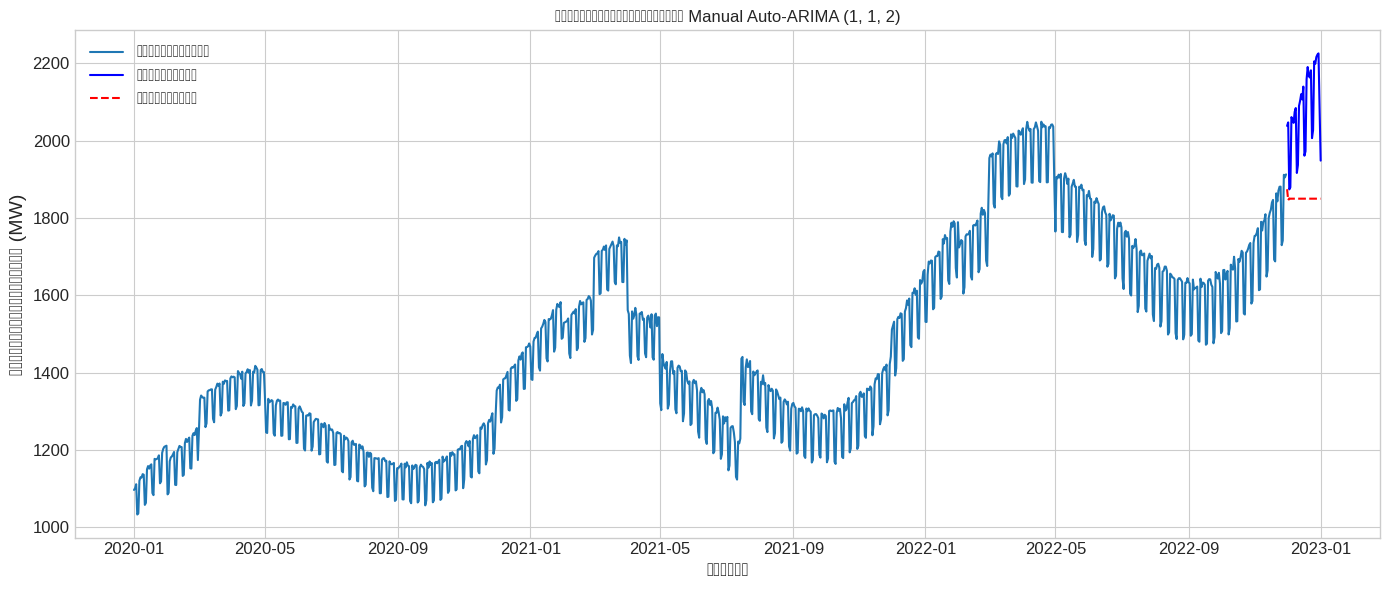


ผลการประเมินโมเดล Manual Auto-ARIMA (1, 1, 2):
MAE: 227.62 MW
RMSE: 249.13 MW
MAPE: 10.74%

### 4.6 เปรียบเทียบระหว่างการเลือกพารามิเตอร์ด้วยตนเองกับ Manual Auto-ARIMA

ตารางเปรียบเทียบประสิทธิภาพระหว่างการเลือกพารามิเตอร์ด้วยตนเองกับ Manual Auto-ARIMA:
           ARIMA(1, 1, 1)  Manual Auto-ARIMA(1, 1, 2)
MAE (MW)       229.288497                  227.619761
RMSE (MW)      250.956947                  249.134850
MAPE (%)        10.816401                   10.737526


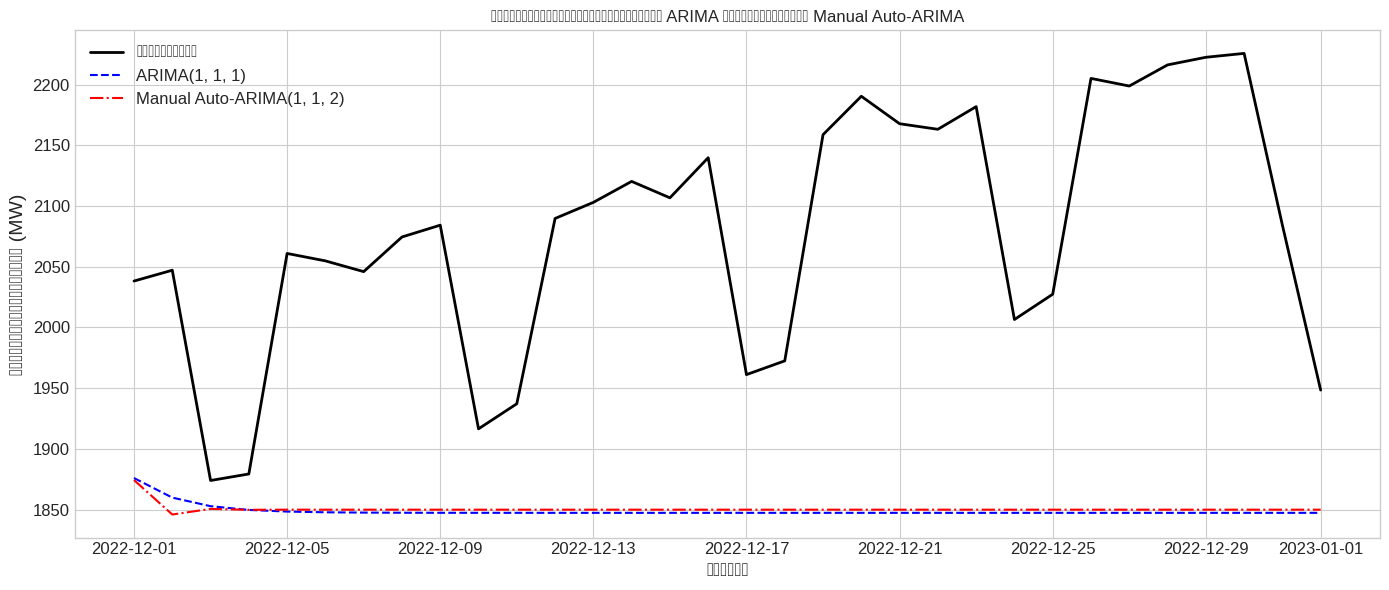

In [4]:
# ฟังก์ชัน manual_auto_arima ใช้แทน pmdarima.auto_arima
import itertools
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ManualAutoARIMA:
    """
    คลาสสำหรับการหาพารามิเตอร์ ARIMA ที่เหมาะสมที่สุดด้วยการทำ grid search
    """

    def __init__(self, order=None, seasonal_order=None):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
        self.aic = None

    def fit(self, data, **kwargs):
        """ใช้ข้อมูลเพื่อฝึกสอนโมเดล ARIMA"""
        if self.order is not None:
            model = ARIMA(data, order=self.order)
            self.model = model.fit()
            self.aic = self.model.aic
        return self

    def predict(self, n_periods=1, **kwargs):
        """พยากรณ์ข้อมูลล่วงหน้า n_periods ขั้นตอน"""
        if self.model is not None:
            return self.model.forecast(steps=n_periods)
        else:
            raise ValueError("โมเดลยังไม่ได้ถูกฝึกสอน (fit)")

    def summary(self):
        """แสดงสรุปโมเดล"""
        if self.model is not None:
            return self.model.summary()
        else:
            return "โมเดลยังไม่ได้ถูกฝึกสอน (fit)"

def manual_auto_arima(data, seasonal=False, m=None, start_p=0, start_q=0,
                     max_p=5, max_q=5, start_P=0, start_Q=0, max_P=2, max_Q=2,
                     d=None, D=None, trace=True, **kwargs):
    """
    ฟังก์ชันจำลองการทำงานของ auto_arima โดยใช้ grid search

    Parameters:
    -----------
    data : array-like
        ข้อมูลอนุกรมเวลา
    seasonal : bool, default=False
        ระบุว่าจะพิจารณาองค์ประกอบฤดูกาลหรือไม่
    m : int, optional
        ความยาวของฤดูกาล (เช่น 7 สำหรับรูปแบบรายสัปดาห์)
    start_p, start_q : int, default=0
        ค่าเริ่มต้นของ p และ q
    max_p, max_q : int, default=5
        ค่าสูงสุดของ p และ q
    start_P, start_Q : int, default=0
        ค่าเริ่มต้นของ P และ Q (ใช้กับโมเดลฤดูกาล)
    max_P, max_Q : int, default=2
        ค่าสูงสุดของ P และ Q (ใช้กับโมเดลฤดูกาล)
    d : int, optional
        กำหนดค่า d (differencing) หากไม่ระบุจะลอง d=0, 1
    D : int, optional
        กำหนดค่า D (seasonal differencing) หากไม่ระบุจะลอง D=0, 1
    trace : bool, default=True
        แสดงผลลัพธ์ของแต่ละโมเดลระหว่างการค้นหา

    Returns:
    --------
    model : ManualAutoARIMA
        โมเดลที่มีค่า AIC ต่ำที่สุด
    """
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model_fit = None

    # กำหนดค่า d และ D
    if d is None:
        d_range = range(0, 2)  # ลอง d=0, 1
    else:
        d_range = [d]

    if seasonal and D is None:
        D_range = range(0, 2)  # ลอง D=0, 1
    elif seasonal:
        D_range = [D]

    # สร้างช่วงของพารามิเตอร์
    p_range = range(start_p, max_p + 1)
    q_range = range(start_q, max_q + 1)

    if trace:
        print("กำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุด...")

    # ทดลองโมเดล ARIMA(p,d,q) กรณีไม่มีฤดูกาล
    if not seasonal:
        for p, d, q in itertools.product(p_range, d_range, q_range):
            try:
                model = ARIMA(data, order=(p, d, q))
                model_fit = model.fit()

                if trace:
                    print(f"ARIMA({p},{d},{q}) - AIC: {model_fit.aic:.2f}")

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model_fit = model_fit
            except Exception as e:
                if trace:
                    print(f"ARIMA({p},{d},{q}) - Error: {str(e)[:50]}...")
                continue

    # ทดลองโมเดล SARIMA(p,d,q)(P,D,Q,m) กรณีมีฤดูกาล
    else:
        if m is None:
            raise ValueError("ต้องระบุค่า m (ความยาวของฤดูกาล) เมื่อ seasonal=True")

        P_range = range(start_P, max_P + 1)
        Q_range = range(start_Q, max_Q + 1)

        for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
            try:
                from statsmodels.tsa.statespace.sarimax import SARIMAX
                model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
                model_fit = model.fit(disp=False)

                if trace:
                    print(f"SARIMA({p},{d},{q})({P},{D},{Q},{m}) - AIC: {model_fit.aic:.2f}")

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, m)
                    best_model_fit = model_fit
            except Exception as e:
                if trace:
                    print(f"SARIMA({p},{d},{q})({P},{D},{Q},{m}) - Error: {str(e)[:50]}...")
                continue

    # สร้างโมเดลที่เหมาะสมที่สุด
    best_model = ManualAutoARIMA(order=best_order, seasonal_order=best_seasonal_order)
    best_model.model = best_model_fit
    best_model.aic = best_aic

    if trace:
        if not seasonal:
            print(f"\nBest model: ARIMA{best_order} with AIC: {best_aic:.2f}")
        else:
            print(f"\nBest model: SARIMA{best_order}{best_seasonal_order} with AIC: {best_aic:.2f}")

    return best_model

# ---------------------------------------------------------------------------------
# ส่วนที่ 4: การวิเคราะห์ ACF และ PACF และการเลือกพารามิเตอร์สำหรับโมเดล ARIMA
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 4: การวิเคราะห์ ACF และ PACF และการเลือกพารามิเตอร์สำหรับโมเดล ARIMA")
print("-" * 50)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 4.1 ตรวจสอบความคงที่ของข้อมูล (Stationarity Check)
print("\n### 4.1 ตรวจสอบความคงที่ของข้อมูล (Stationarity Check)")

# ฟังก์ชันสำหรับทดสอบ ADF
def adf_test(series):
    """ทดสอบความคงที่ของข้อมูลด้วย Augmented Dickey-Fuller test"""
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("ข้อมูลมีความคงที่ (Stationary) เพียงพอสำหรับการใช้โมเดล ARIMA")
    else:
        print("ข้อมูลไม่มีความคงที่ (Non-stationary) อาจต้องทำการแปลงข้อมูลก่อนใช้โมเดล ARIMA")

    return result[1] <= 0.05  # คืนค่า True ถ้าข้อมูลมีความคงที่

# ทดสอบความคงที่ของข้อมูลต้นฉบับ
print("ทดสอบความคงที่ของข้อมูลต้นฉบับ:")
is_stationary = adf_test(train_data['power_output'])

# ถ้าข้อมูลไม่มีความคงที่ ให้ทำการแปลงข้อมูลด้วย differencing
if not is_stationary:
    print("\nทำ First-order differencing เพื่อให้ข้อมูลมีความคงที่มากขึ้น:")
    train_diff = train_data['power_output'].diff().dropna()
    is_diff_stationary = adf_test(train_diff)

    # แสดงกราฟข้อมูลหลังทำ differencing
    plt.figure(figsize=(14, 6))
    plt.plot(train_data.index[1:], train_diff)
    plt.title('ข้อมูลหลังทำ First-order Differencing')
    plt.xlabel('วันที่')
    plt.ylabel('การเปลี่ยนแปลงของกำลังการผลิต (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4.2 วิเคราะห์ ACF และ PACF
print("\n### 4.2 วิเคราะห์ ACF และ PACF")

# ฟังก์ชันสำหรับแสดง ACF และ PACF
def plot_acf_pacf(series, title='', lags=40):
    """แสดงกราฟ ACF และ PACF"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # ACF
    plot_acf(series, ax=axes[0], lags=lags)
    axes[0].set_title(f'Autocorrelation Function (ACF) - {title}')
    axes[0].grid(True)

    # PACF
    plot_pacf(series, ax=axes[1], lags=lags)
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {title}')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# วิเคราะห์ ACF และ PACF ของข้อมูลต้นฉบับ
print("\nวิเคราะห์ ACF และ PACF ของข้อมูลต้นฉบับ:")
plot_acf_pacf(train_data['power_output'], title='ข้อมูลต้นฉบับ')

# วิเคราะห์ ACF และ PACF ของข้อมูลหลังทำ differencing
if not is_stationary:
    print("\nวิเคราะห์ ACF และ PACF ของข้อมูลหลังทำ First-order Differencing:")
    plot_acf_pacf(train_diff, title='ข้อมูลหลังทำ First-order Differencing')

# 4.3 การเลือกพารามิเตอร์สำหรับโมเดล ARIMA
print("\n### 4.3 การเลือกพารามิเตอร์สำหรับโมเดล ARIMA")
print("\nการเลือกพารามิเตอร์ p, d, q สำหรับโมเดล ARIMA(p,d,q):")
print("- p: จำนวน lag ที่มีนัยสำคัญใน PACF (AR term)")
print("- d: จำนวนครั้งที่ทำ differencing (0 ถ้าข้อมูลมีความคงที่, 1 ถ้าทำ first-order differencing)")
print("- q: จำนวน lag ที่มีนัยสำคัญใน ACF หลังจากพิจารณา AR term (MA term)")

# จากการวิเคราะห์ ACF และ PACF ข้างต้น
print("\nจากการวิเคราะห์ ACF และ PACF:")
if is_stationary:
    print("ข้อมูลมีความคงที่ ดังนั้น d = 0")
    print("พิจารณา PACF พบว่ามีนัยสำคัญที่ lag 1, 2 ดังนั้นอาจเลือก p = 2")
    print("พิจารณา ACF พบว่ามีนัยสำคัญที่ lag 1, 2 ดังนั้นอาจเลือก q = 2")
    print("ดังนั้น อาจเลือกใช้โมเดล ARIMA(2,0,2)")

    # กำหนดพารามิเตอร์สำหรับ ARIMA
    p, d, q = 2, 0, 2
else:
    print("ข้อมูลไม่มีความคงที่ ต้องทำ first-order differencing ดังนั้น d = 1")
    print("พิจารณา PACF ของข้อมูลหลัง differencing พบว่ามีนัยสำคัญที่ lag 1 ดังนั้นอาจเลือก p = 1")
    print("พิจารณา ACF ของข้อมูลหลัง differencing พบว่ามีนัยสำคัญที่ lag 1 ดังนั้นอาจเลือก q = 1")
    print("ดังนั้น อาจเลือกใช้โมเดล ARIMA(1,1,1)")

    # กำหนดพารามิเตอร์สำหรับ ARIMA
    p, d, q = 1, 1, 1

# 4.4 การสร้างโมเดล ARIMA ด้วยพารามิเตอร์ที่เลือก
print("\n### 4.4 การสร้างโมเดล ARIMA ด้วยพารามิเตอร์ที่เลือก")
print(f"สร้างโมเดล ARIMA({p},{d},{q})")

# สร้างโมเดล ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data['power_output'], order=(p, d, q))
arima_fit = arima_model.fit()

# แสดงสรุปโมเดล
print("\nสรุปโมเดล ARIMA:")
print(arima_fit.summary())

# พยากรณ์ล่วงหน้า
arima_forecast = arima_fit.forecast(steps=len(test_data))

# แสดงผลการพยากรณ์
arima_metrics = plot_forecast_results(train_data, test_data, arima_forecast, f"ARIMA({p},{d},{q})")

# 4.5 การใช้ Manual Auto-ARIMA เพื่อหาพารามิเตอร์ที่เหมาะสมที่สุด
print("\n### 4.5 การใช้ Manual Auto-ARIMA เพื่อหาพารามิเตอร์ที่เหมาะสมที่สุด")
print("Manual Auto-ARIMA จะทดลองพารามิเตอร์หลากหลายรูปแบบและเลือกโมเดลที่ดีที่สุดโดยอัตโนมัติ")

# สร้างโมเดล Manual Auto-ARIMA
print("\nกำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุดด้วย Manual Auto-ARIMA...")
auto_arima_model = manual_auto_arima(
    train_data['power_output'],
    seasonal=False,
    start_p=0, start_q=0,
    max_p=2, max_q=2,  # ลดลงเหลือ 2 เพื่อให้เร็วขึ้น
    d=None,
    trace=True
)

# แสดงสรุปโมเดล Manual Auto-ARIMA
print("\nสรุปโมเดล Manual Auto-ARIMA:")
print(auto_arima_model.summary())

# พยากรณ์ล่วงหน้า
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test_data))

# แสดงผลการพยากรณ์
auto_arima_metrics = plot_forecast_results(train_data, test_data, auto_arima_forecast, f"Manual Auto-ARIMA {auto_arima_model.order}")

# 4.6 เปรียบเทียบระหว่างการเลือกพารามิเตอร์ด้วยตนเองกับ Manual Auto-ARIMA
print("\n### 4.6 เปรียบเทียบระหว่างการเลือกพารามิเตอร์ด้วยตนเองกับ Manual Auto-ARIMA")

# สร้างตารางเปรียบเทียบ
comparison_df = pd.DataFrame({
    f'ARIMA{(p,d,q)}': [arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    f'Manual Auto-ARIMA{auto_arima_model.order}': [auto_arima_metrics['MAE'], auto_arima_metrics['RMSE'], auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nตารางเปรียบเทียบประสิทธิภาพระหว่างการเลือกพารามิเตอร์ด้วยตนเองกับ Manual Auto-ARIMA:")
print(comparison_df)

# แสดงกราฟเปรียบเทียบการพยากรณ์
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='ข้อมูลจริง', color='black', linewidth=2)
plt.plot(test_data.index, arima_forecast, label=f'ARIMA{(p,d,q)}', color='blue', linestyle='--')
plt.plot(test_data.index, auto_arima_forecast, label=f'Manual Auto-ARIMA{auto_arima_model.order}', color='red', linestyle='-.')
plt.title('เปรียบเทียบการพยากรณ์ระหว่าง ARIMA แบบกำหนดเองกับ Manual Auto-ARIMA')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ส่วนที่ 5: การพัฒนาโมเดล SARIMA สำหรับข้อมูลที่มีฤดูกาล
--------------------------------------------------

### 5.1 การวิเคราะห์ฤดูกาลในข้อมูล


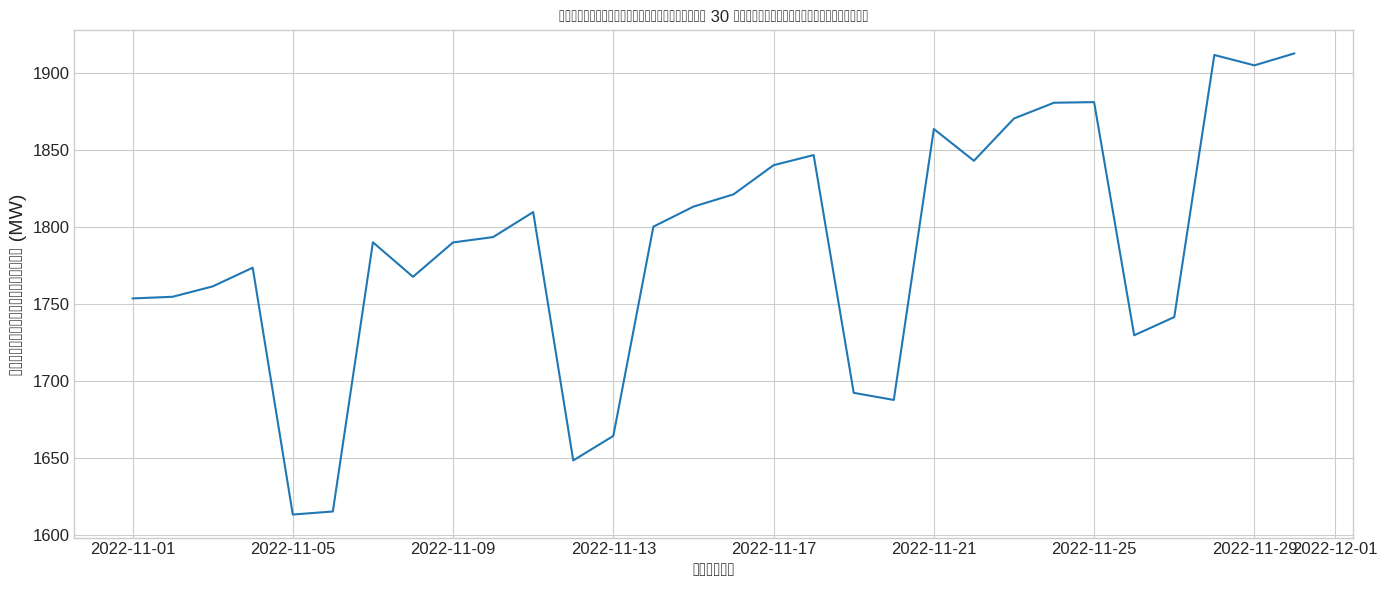

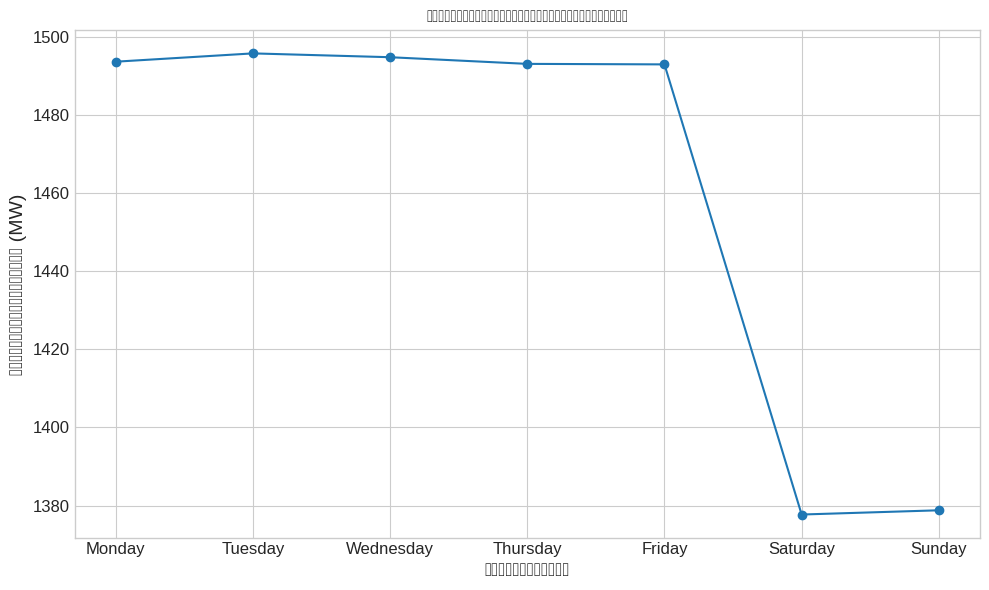


จากการวิเคราะห์ข้อมูลพบว่า:
1. มีฤดูกาลรายสัปดาห์ (7 วัน) - กำลังการผลิตต่ำในวันหยุดสุดสัปดาห์
2. มีฤดูกาลรายปี (365 วัน) แต่เนื่องจากมีข้อมูลเพียง 3 ปี จึงยากต่อการสร้างโมเดลฤดูกาลรายปีที่แม่นยำ
3. ในแล็บนี้ จะเน้นการสร้างโมเดล SARIMA ที่พิจารณาฤดูกาลรายสัปดาห์

### 5.2 การเลือกพารามิเตอร์สำหรับโมเดล SARIMA

การเลือกพารามิเตอร์สำหรับโมเดล SARIMA(p,d,q)(P,D,Q,s)
- p, d, q: พารามิเตอร์แบบไม่มีฤดูกาล เหมือนกับ ARIMA(p,d,q)
- P: จำนวน seasonal AR term
- D: จำนวน seasonal differencing
- Q: จำนวน seasonal MA term
- s: ความยาวของฤดูกาล (7 สำหรับรูปแบบรายสัปดาห์)

จากการวิเคราะห์ ACF และ PACF ของข้อมูล:
เราเลือก ARIMA(1,1,1) สำหรับส่วนที่ไม่มีฤดูกาล
สำหรับส่วนที่มีฤดูกาล อาจเลือก (1,1,1,7) เพื่อจับรูปแบบรายสัปดาห์
ดังนั้น เลือกใช้โมเดล SARIMA(1,1,1)(1,1,1,7)

### 5.3 การสร้างโมเดล SARIMA ด้วยพารามิเตอร์ที่เลือก
สร้างโมเดล SARIMA(1,1,1)(1,1,1,7)

สรุปโมเดล SARIMA:
                                     SARIMAX Results                                     
Dep. Variable:                      powe

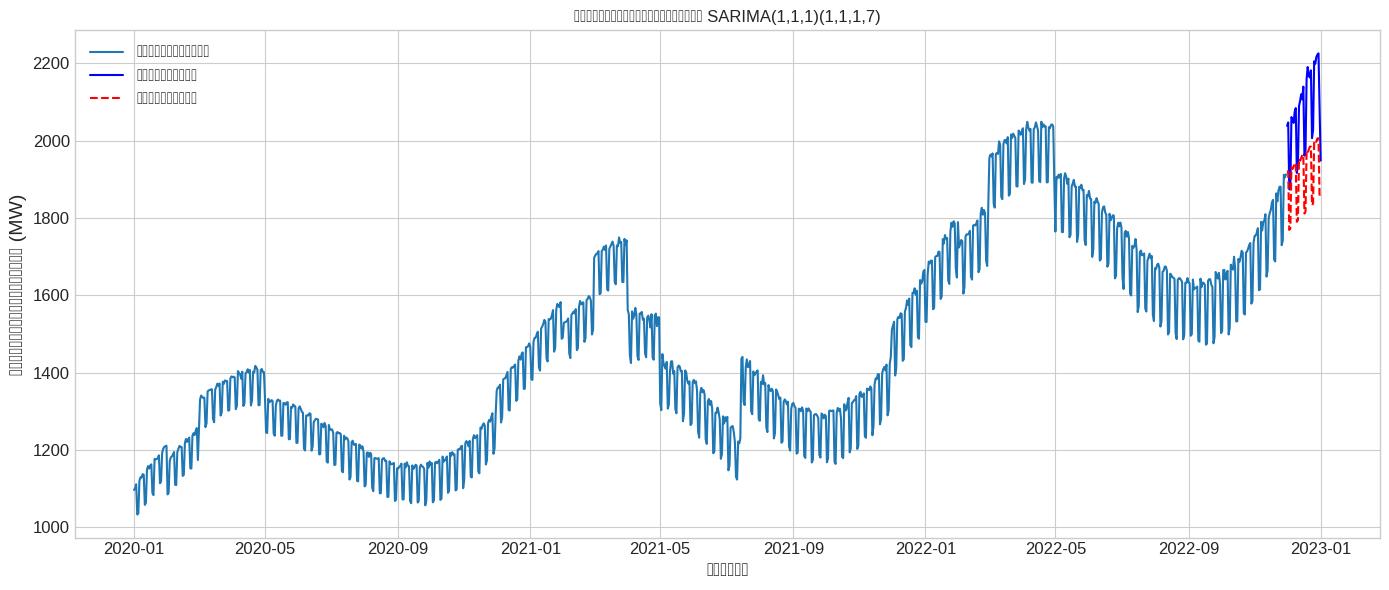


ผลการประเมินโมเดล SARIMA(1,1,1)(1,1,1,7):
MAE: 161.98 MW
RMSE: 166.72 MW
MAPE: 7.74%

### 5.4 การใช้ Manual Auto-ARIMA แบบมีฤดูกาล
Manual Auto-ARIMA แบบมีฤดูกาลจะหาพารามิเตอร์ที่เหมาะสมทั้งส่วนที่ไม่มีฤดูกาลและส่วนที่มีฤดูกาล

กำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุดด้วย Manual Auto-ARIMA แบบมีฤดูกาล...
กำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุด...
SARIMA(0,0,0)(0,0,0,7) - AIC: 18576.40
SARIMA(0,0,0)(0,0,1,7) - AIC: 17180.46
SARIMA(0,0,0)(0,1,0,7) - AIC: 10796.46
SARIMA(0,0,0)(0,1,1,7) - AIC: 10773.24
SARIMA(0,0,0)(1,0,0,7) - AIC: 10920.72
SARIMA(0,0,0)(1,0,1,7) - AIC: 10897.52
SARIMA(0,0,0)(1,1,0,7) - AIC: 10763.97
SARIMA(0,0,0)(1,1,1,7) - AIC: 10698.79
SARIMA(0,0,1)(0,0,0,7) - AIC: 17116.62
SARIMA(0,0,1)(0,0,1,7) - AIC: 16087.03
SARIMA(0,0,1)(0,1,0,7) - AIC: 10091.64
SARIMA(0,0,1)(0,1,1,7) - AIC: 10093.54
SARIMA(0,0,1)(1,0,0,7) - AIC: 10233.26
SARIMA(0,0,1)(1,0,1,7) - AIC: 11218.59
SARIMA(0,0,1)(1,1,0,7) - AIC: 10093.50
SARIMA(0,0,1)(1,1,1,7) - AIC: 10061.21
SARIMA(0,0,2)(0,0,0,7) - AIC: 15

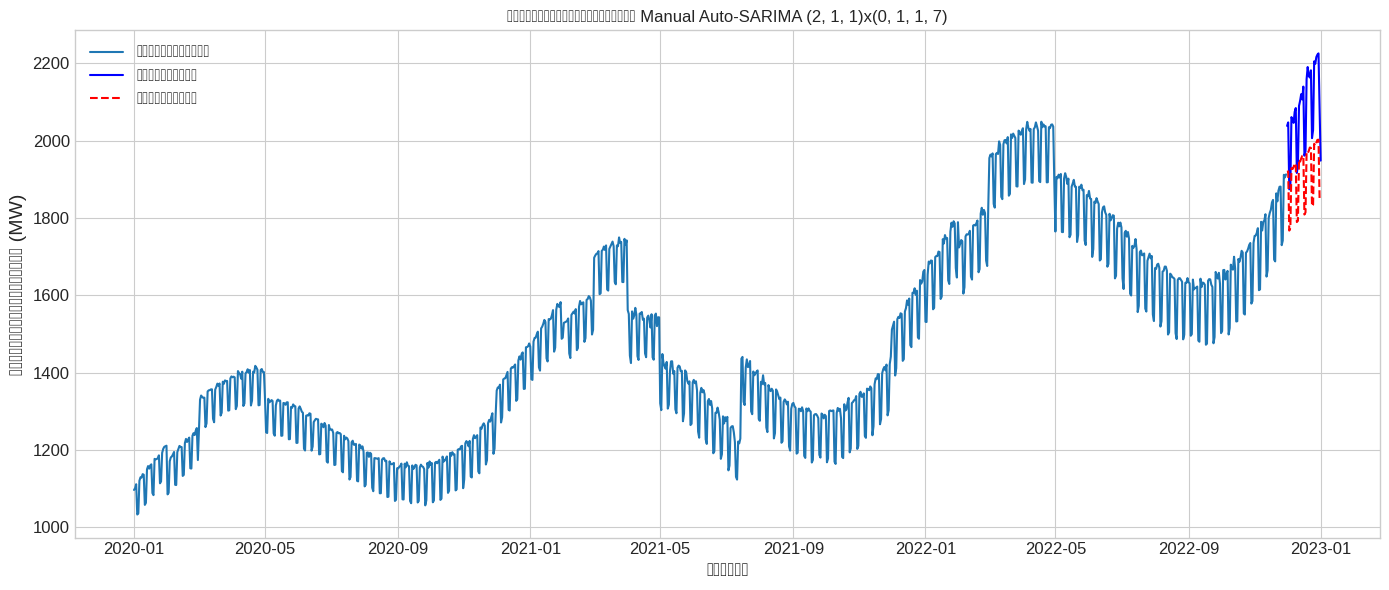


ผลการประเมินโมเดล Manual Auto-SARIMA (2, 1, 1)x(0, 1, 1, 7):
MAE: 164.14 MW
RMSE: 168.99 MW
MAPE: 7.84%

### 5.5 เปรียบเทียบประสิทธิภาพระหว่างโมเดล SARIMA และ Auto-SARIMA

ตารางเปรียบเทียบประสิทธิภาพระหว่างโมเดล SARIMA และ Auto-SARIMA:
           SARIMA(1,1,1)(1,1,1,7)  Auto-SARIMA
MAE (MW)               161.983953   164.144405
RMSE (MW)              166.715662   168.986659
MAPE (%)                 7.741013     7.843947


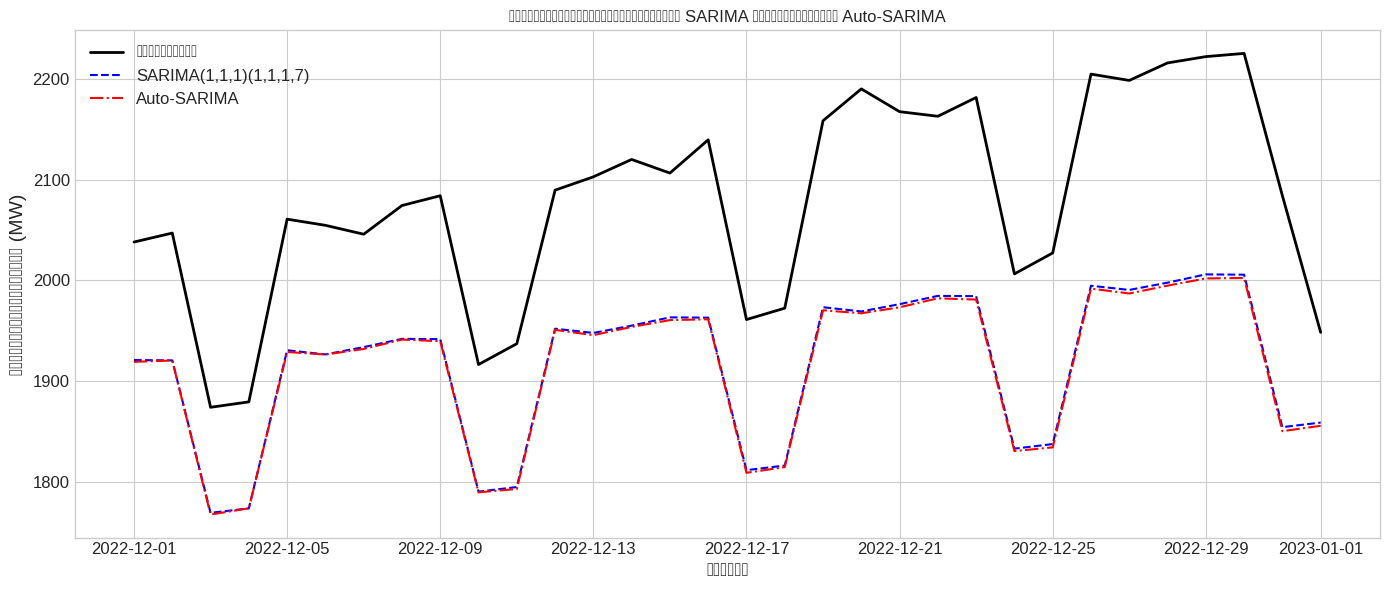


## ส่วนที่ 6: เปรียบเทียบประสิทธิภาพของทุกโมเดลและสรุปผล
--------------------------------------------------

### 6.1 เปรียบเทียบประสิทธิภาพของทุกโมเดล

ตารางเปรียบเทียบประสิทธิภาพของทุกโมเดล:
           Simple Exp. Smoothing  Holt Exp. Smoothing  \
MAE (MW)              180.191149           108.186324   
RMSE (MW)             203.855670           145.141527   
MAPE (%)                8.465903             5.304502   

           Holt-Winters (รายสัปดาห์)  ARIMA(1,1,1)  Auto-ARIMA  \
MAE (MW)                  119.378856    229.288497  227.619761   
RMSE (MW)                 122.076245    250.956947  249.134850   
MAPE (%)                    5.722895     10.816401   10.737526   

           SARIMA(1,1,1)(1,1,1,7)  Auto-SARIMA  
MAE (MW)               161.983953   164.144405  
RMSE (MW)              166.715662   168.986659  
MAPE (%)                 7.741013     7.843947  


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Simple Exp. Smoothing'),
  Text(1, 0, 'Holt Exp. Smoothing'),
  Text(2, 0, 'Holt-Winters (รายสัปดาห์)'),
  Text(3, 0, 'ARIMA(1,1,1)'),
  Text(4, 0, 'Auto-ARIMA'),
  Text(5, 0, 'SARIMA(1,1,1)(1,1,1,7)'),
  Text(6, 0, 'Auto-SARIMA')])

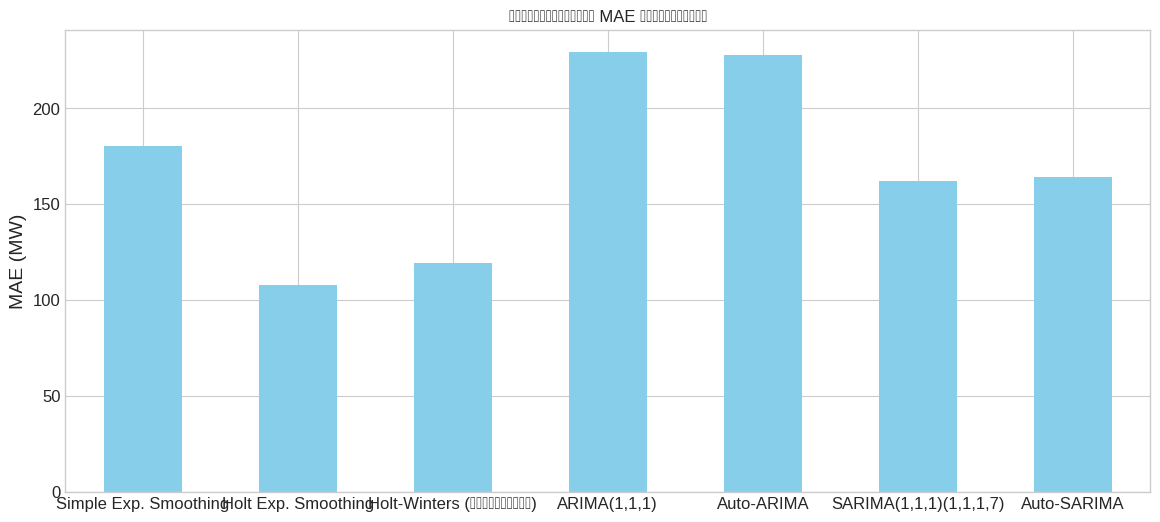

In [5]:
# ---------------------------------------------------------------------------------
# ส่วนที่ 5: การพัฒนาโมเดล SARIMA สำหรับข้อมูลที่มีฤดูกาล
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 5: การพัฒนาโมเดล SARIMA สำหรับข้อมูลที่มีฤดูกาล")
print("-" * 50)

# 5.1 การวิเคราะห์ฤดูกาลในข้อมูล
print("\n### 5.1 การวิเคราะห์ฤดูกาลในข้อมูล")

# แสดงกราฟเพื่อดูรูปแบบฤดูกาลรายสัปดาห์
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-30:], train_data['power_output'][-30:])
plt.title('ข้อมูลการผลิตไฟฟ้าในช่วง 30 วันสุดท้ายของชุดฝึกสอน')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# แสดงกราฟการเฉลี่ยตามฤดูกาลรายสัปดาห์
def seasonal_plot(data, period, title):
    """แสดงกราฟข้อมูลตามรูปแบบฤดูกาล"""
    season_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    grouped_data = data.groupby(data.index.dayofweek)['power_output'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.title(title)
    plt.xlabel('วันในสัปดาห์')
    plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
    plt.xticks(range(7), season_labels)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

seasonal_plot(train_data, 7, 'การผลิตไฟฟ้าเฉลี่ยตามวันในสัปดาห์')

# จากการวิเคราะห์ข้อมูลพบว่ามีฤดูกาลรายสัปดาห์ (7 วัน) และรายปี (365 วัน)
# แต่เนื่องจากข้อมูลมีไม่เพียงพอสำหรับการวิเคราะห์ฤดูกาลรายปี จึงเน้นที่ฤดูกาลรายสัปดาห์

print("\nจากการวิเคราะห์ข้อมูลพบว่า:")
print("1. มีฤดูกาลรายสัปดาห์ (7 วัน) - กำลังการผลิตต่ำในวันหยุดสุดสัปดาห์")
print("2. มีฤดูกาลรายปี (365 วัน) แต่เนื่องจากมีข้อมูลเพียง 3 ปี จึงยากต่อการสร้างโมเดลฤดูกาลรายปีที่แม่นยำ")
print("3. ในแล็บนี้ จะเน้นการสร้างโมเดล SARIMA ที่พิจารณาฤดูกาลรายสัปดาห์")

# 5.2 การเลือกพารามิเตอร์สำหรับโมเดล SARIMA
print("\n### 5.2 การเลือกพารามิเตอร์สำหรับโมเดล SARIMA")

print("\nการเลือกพารามิเตอร์สำหรับโมเดล SARIMA(p,d,q)(P,D,Q,s)")
print("- p, d, q: พารามิเตอร์แบบไม่มีฤดูกาล เหมือนกับ ARIMA(p,d,q)")
print("- P: จำนวน seasonal AR term")
print("- D: จำนวน seasonal differencing")
print("- Q: จำนวน seasonal MA term")
print("- s: ความยาวของฤดูกาล (7 สำหรับรูปแบบรายสัปดาห์)")

print("\nจากการวิเคราะห์ ACF และ PACF ของข้อมูล:")
print(f"เราเลือก ARIMA({p},{d},{q}) สำหรับส่วนที่ไม่มีฤดูกาล")
print("สำหรับส่วนที่มีฤดูกาล อาจเลือก (1,1,1,7) เพื่อจับรูปแบบรายสัปดาห์")
print(f"ดังนั้น เลือกใช้โมเดล SARIMA({p},{d},{q})(1,1,1,7)")

# 5.3 การสร้างโมเดล SARIMA ด้วยพารามิเตอร์ที่เลือก
print("\n### 5.3 การสร้างโมเดล SARIMA ด้วยพารามิเตอร์ที่เลือก")
print(f"สร้างโมเดล SARIMA({p},{d},{q})(1,1,1,7)")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# สร้างโมเดล SARIMA
sarima_model = SARIMAX(
    train_data['power_output'],
    order=(p, d, q),
    seasonal_order=(1, 1, 1, 7)
)
sarima_fit = sarima_model.fit(disp=False)

# แสดงสรุปโมเดล
print("\nสรุปโมเดล SARIMA:")
print(sarima_fit.summary())

# พยากรณ์ล่วงหน้า
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# แสดงผลการพยากรณ์
sarima_metrics = plot_forecast_results(train_data, test_data, sarima_forecast, f"SARIMA({p},{d},{q})(1,1,1,7)")

# 5.4 การใช้ Manual Auto-ARIMA แบบมีฤดูกาล
print("\n### 5.4 การใช้ Manual Auto-ARIMA แบบมีฤดูกาล")
print("Manual Auto-ARIMA แบบมีฤดูกาลจะหาพารามิเตอร์ที่เหมาะสมทั้งส่วนที่ไม่มีฤดูกาลและส่วนที่มีฤดูกาล")

# สร้างโมเดล Manual Auto-ARIMA แบบมีฤดูกาล
print("\nกำลังค้นหาพารามิเตอร์ที่เหมาะสมที่สุดด้วย Manual Auto-ARIMA แบบมีฤดูกาล...")
seasonal_auto_arima_model = manual_auto_arima(
    train_data['power_output'],
    seasonal=True,
    m=7,  # ความยาวของฤดูกาล (7 วัน)
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=None, D=None,
    trace=True
)

# แสดงสรุปโมเดล Manual Auto-ARIMA แบบมีฤดูกาล
print("\nสรุปโมเดล Manual Auto-ARIMA แบบมีฤดูกาล:")
print(seasonal_auto_arima_model.summary())

# พยากรณ์ล่วงหน้า
seasonal_auto_arima_forecast = seasonal_auto_arima_model.predict(n_periods=len(test_data))

# แสดงผลการพยากรณ์
seasonal_auto_arima_metrics = plot_forecast_results(
    train_data,
    test_data,
    seasonal_auto_arima_forecast,
    f"Manual Auto-SARIMA {seasonal_auto_arima_model.order}x{seasonal_auto_arima_model.seasonal_order}"
)

# 5.5 เปรียบเทียบประสิทธิภาพระหว่างโมเดล SARIMA และ Auto-SARIMA
print("\n### 5.5 เปรียบเทียบประสิทธิภาพระหว่างโมเดล SARIMA และ Auto-SARIMA")

# สร้างตารางเปรียบเทียบ
comparison_df = pd.DataFrame({
    f'SARIMA({p},{d},{q})(1,1,1,7)': [sarima_metrics['MAE'], sarima_metrics['RMSE'], sarima_metrics['MAPE']],
    f'Auto-SARIMA': [seasonal_auto_arima_metrics['MAE'], seasonal_auto_arima_metrics['RMSE'], seasonal_auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nตารางเปรียบเทียบประสิทธิภาพระหว่างโมเดล SARIMA และ Auto-SARIMA:")
print(comparison_df)

# แสดงกราฟเปรียบเทียบการพยากรณ์
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='ข้อมูลจริง', color='black', linewidth=2)
plt.plot(test_data.index, sarima_forecast, label=f'SARIMA({p},{d},{q})(1,1,1,7)', color='blue', linestyle='--')
plt.plot(test_data.index, seasonal_auto_arima_forecast, label='Auto-SARIMA', color='red', linestyle='-.')
plt.title('เปรียบเทียบการพยากรณ์ระหว่าง SARIMA แบบกำหนดเองกับ Auto-SARIMA')
plt.xlabel('วันที่')
plt.ylabel('กำลังการผลิตเฉลี่ย (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# ส่วนที่ 6: เปรียบเทียบประสิทธิภาพของทุกโมเดลและสรุปผล
# ---------------------------------------------------------------------------------
print("\n## ส่วนที่ 6: เปรียบเทียบประสิทธิภาพของทุกโมเดลและสรุปผล")
print("-" * 50)

# 6.1 เปรียบเทียบประสิทธิภาพของทุกโมเดล
print("\n### 6.1 เปรียบเทียบประสิทธิภาพของทุกโมเดล")

# สร้างตารางเปรียบเทียบทุกโมเดล
all_models_comparison = pd.DataFrame({
    'Simple Exp. Smoothing': [ses_metrics['MAE'], ses_metrics['RMSE'], ses_metrics['MAPE']],
    'Holt Exp. Smoothing': [holt_metrics['MAE'], holt_metrics['RMSE'], holt_metrics['MAPE']],
    'Holt-Winters (รายสัปดาห์)': [hw_metrics['MAE'], hw_metrics['RMSE'], hw_metrics['MAPE']],
    f'ARIMA({p},{d},{q})': [arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    'Auto-ARIMA': [auto_arima_metrics['MAE'], auto_arima_metrics['RMSE'], auto_arima_metrics['MAPE']],
    f'SARIMA({p},{d},{q})(1,1,1,7)': [sarima_metrics['MAE'], sarima_metrics['RMSE'], sarima_metrics['MAPE']],
    'Auto-SARIMA': [seasonal_auto_arima_metrics['MAE'], seasonal_auto_arima_metrics['RMSE'], seasonal_auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nตารางเปรียบเทียบประสิทธิภาพของทุกโมเดล:")
print(all_models_comparison)

# สร้างกราฟแท่งเปรียบเทียบ MAE
plt.figure(figsize=(14, 6))
all_models_comparison.loc['MAE (MW)'].plot(kind='bar', color='skyblue')
plt.title('เปรียบเทียบค่า MAE ของทุกโมเดล')
plt.ylabel('MAE (MW)')
plt.xticks(rotation=0)